# Used Car Regression (Part 1)

In this project we will use polynomial regression to predict the price of used cars. We will start by building a simple linear regression model, and we will later add interaction and higher order terms. 

In [1]:
import numpy as np
import pandas as pd

car = pd.read_csv('Car details v3.csv')

# Data Cleaning and Exploration

In [2]:
car.shape

(8128, 13)

In [3]:
car.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [5]:
car.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


The data set contains roughly 8k data points and has 13 columns. Most of the columns are objects although some of them (like seats) might be converted to integer. We see that there are some obvious outliers. For example, the median of `selling_price` is 450k, but the maximum is 1 million. Also, the median of `km_driven` is 60k, bit the minimum is 1, which means that the car has never been used. Also, we notice that there is at least 1 vehicle with 14 seats, which is certainly not what we would expect for a normal car. 

First, to make the data easier to understand, let's convert price to USD.

In [6]:
df = car.copy()
df.selling_price = df.selling_price * 0.012

In [7]:
df.selling_price.describe()

count      8128.000000
mean       7659.261692
std        9675.040842
min         359.988000
25%        3059.988000
50%        5400.000000
75%        8100.000000
max      120000.000000
Name: selling_price, dtype: float64

Thus, the median is 5.4k dollars and the mean is almost 8k dollars. The maximum value of 120k dollars is almost certainly an outlier. 

Before removing the outliers, let's convert mileage, engine, and max_power into numerical data. Also, we will drop torque since it seems to be technical data not too useful to predict the price of used cars. 

In [8]:
df.drop(['torque'], axis=1, inplace=True)

Let's also drop the rows containing null values.

In [9]:
df.dropna(inplace=True)

In [10]:
df.mileage.str[-5:].value_counts()

 kmpl    7819
km/kg      88
Name: mileage, dtype: int64

It is unclear whether km/kg is a typo or it means km per kg of fuel. Since 1 kg of fuel is not necessarily 1 liter, we will just drop these rows.

In [11]:
df.drop(df[df['mileage'].str.endswith('km/kg')].index, inplace=True)
df.mileage.str[-5:].value_counts()

 kmpl    7819
Name: mileage, dtype: int64

In [12]:
df['mileage'] = df['mileage'].astype(str)
df['mileage'] = df['mileage'].str.replace(' kmpl', '').astype(float)

df['engine'] = df['engine'].astype(str)
df['engine'] = df['engine'].str.replace(' CC', '').astype(int)

df['max_power'] = df['max_power'].astype(str)
df['max_power'] = df['max_power'].str.replace(' bhp', '').astype(float)

In [13]:
df.rename(columns={'mileage': 'mileage_kmpl',
                   'engine':'engine_CC',
                   'max_power':'max_power_bhp'}, inplace=True)

In [14]:
df.describe()

,year,selling_price,km_driven,mileage_kmpl,engine_CC,max_power_bhp,seats
count,7819.000000,7819.000000,7.819000e+03,7819.000000,7819.000000,7819.000000,7819.000000
mean,2013.990280,7847.830075,6.912583e+04,19.390375,1463.090677,91.935226,5.421281
std,3.865268,9804.634591,5.687384e+04,4.001777,504.655439,35.770104,0.962876
min,1994.000000,359.988000,1.000000e+03,0.000000,624.000000,34.200000,2.000000
25%,2012.000000,3240.000000,3.400000e+04,16.780000,1197.000000,69.000000,5.000000
50%,2015.000000,5460.000000,6.000000e+04,19.300000,1248.000000,82.400000,5.000000
75%,2017.000000,8340.000000,9.600000e+04,22.320000,1582.000000,102.000000,5.000000
max,2020.000000,120000.000000,2.360457e+06,42.000000,3604.000000,400.000000,14.000000


We now see other potential errors in the data, like a car that has a mileage of 0 kmpl. Let's remove the outliers.

### Dealing with Outliers

Since we want to do a linear regression, removing the outliers is very important. Let's check how many of them there are in the data.

In [15]:
def find_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    non_outlier_range = (df[column_name] >= Q1 - 1.5 * IQR) & (df[column_name] <= Q3 + 1.5 * IQR)

    outliers = df[~non_outlier_range]

    return outliers

In [16]:
for column in ['year','selling_price','km_driven','mileage_kmpl','engine_CC','max_power_bhp','seats']:
    print(f'{column} number of outliers =',find_outliers(df,column).shape[0])

year number of outliers = 165
selling_price number of outliers = 594
km_driven number of outliers = 178
mileage_kmpl number of outliers = 18
engine_CC number of outliers = 1183
max_power_bhp number of outliers = 579
seats number of outliers = 1647


If we define outliers like we did in the above function, a lot of data would be dropped. Let's try to make our definition of outlier less strict. 

In [17]:
def find_outliers_less_strict(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    non_outlier_range = (df[column_name] >= Q1 - 2 * IQR) & (df[column_name] <= Q3 + 2 * IQR)

    outliers = df[~non_outlier_range]

    return outliers

In [18]:
for column in ['year','selling_price','km_driven','mileage_kmpl','engine_CC','max_power_bhp','seats']:
    print(f'{column} number of outliers =',find_outliers_less_strict(df,column).shape[0])

year number of outliers = 58
selling_price number of outliers = 517
km_driven number of outliers = 81
mileage_kmpl number of outliers = 18
engine_CC number of outliers = 781
max_power_bhp number of outliers = 473
seats number of outliers = 1647


This doesn't help too much. Let's explore the features of these outliers. 

In [19]:
seat_outliers = find_outliers(df,'seats')
seat_outliers.describe()

,year,selling_price,km_driven,mileage_kmpl,engine_CC,max_power_bhp,seats
count,1647.000000,1647.000000,1.647000e+03,1647.000000,1647.000000,1647.000000,1647.00000
mean,2013.342441,8708.441894,9.108898e+04,15.775811,2002.370978,103.471925,7.00000
std,4.118746,8260.322754,6.751323e+04,3.510874,630.466457,40.276769,1.11545
min,1994.000000,359.988000,1.000000e+03,0.000000,624.000000,34.200000,2.00000
25%,2011.500000,4620.000000,5.000000e+04,13.000000,1462.000000,73.740000,7.00000
50%,2014.000000,7200.000000,8.000000e+04,15.400000,2179.000000,100.600000,7.00000
75%,2016.000000,10200.000000,1.200000e+05,16.800000,2494.000000,138.100000,7.00000
max,2020.000000,120000.000000,1.500000e+06,42.000000,3198.000000,400.000000,14.00000


Some are cars with 2 seats and some are cars with 7 seats. This is reasonable and these data points should not be labeled as outliers. However, the cars with 14 seats are still arguably outliers. Let's check how many of them there are in the data set.

In [20]:
seat_outliers.seats.value_counts()

7.0     1119
8.0      235
4.0      129
9.0       80
6.0       62
10.0      19
2.0        2
14.0       1
Name: seats, dtype: int64

There is only one car like this, so we can just drop this single data point. We will keep the data points of the cars with up to 10 seats.

In [21]:
df.drop(df[df.seats==14.0].index, inplace=True)

Let's do the same check for engine_CC.

In [22]:
engine_CC_outliers = find_outliers(df,'engine_CC')
engine_CC_outliers.describe()

,year,selling_price,km_driven,mileage_kmpl,engine_CC,max_power_bhp,seats
count,1183.000000,1183.000000,1.183000e+03,1183.000000,1183.000000,1183.000000,1183.000000
mean,2013.444632,12454.904054,1.000894e+05,14.244903,2448.201183,126.004294,7.022823
std,3.399776,12955.212892,7.495715e+04,2.504206,252.275542,45.788624,1.058518
min,2002.000000,1152.000000,1.000000e+03,0.000000,2179.000000,62.100000,2.000000
25%,2011.000000,5400.000000,6.000000e+04,12.800000,2179.000000,100.600000,7.000000
50%,2014.000000,8400.000000,9.000000e+04,13.930000,2494.000000,120.000000,7.000000
75%,2016.000000,13632.000000,1.200000e+05,15.960000,2523.000000,147.940000,7.000000
max,2020.000000,86400.000000,1.500000e+06,22.370000,3604.000000,282.000000,10.000000


While these values of engine_CC are quite high, these data points don't seem too concerning. We notice that the median of the number of the number of seats, mileage_kmpl, and selling_price are higher than the rest of the data. This indicates that these outliers describe larger vehicles that require more power. Since these vehicles are not so uncommon, it would be good if our model could deal with them and so we will keep them. We will just drop a few very large values. 

In [23]:
engine_CC_outliers[engine_CC_outliers.engine_CC>3000].shape

(12, 12)

In [24]:
df.drop(df[df.engine_CC>3000].index, inplace=True)

Let's now the outliers in the target column. 

In [25]:
selling_price_outliers = find_outliers(df,'selling_price')
selling_price_outliers.describe()

,year,selling_price,km_driven,mileage_kmpl,engine_CC,max_power_bhp,seats
count,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000
mean,2017.258944,35525.907823,36327.693356,16.354923,2208.180579,175.485486,5.522998
std,1.827287,17561.981626,31193.875985,3.424070,372.676842,30.702796,0.949618
min,2010.000000,15900.000000,1000.000000,0.000000,1364.000000,86.790000,4.000000
25%,2016.000000,21000.000000,10000.000000,13.680000,1984.000000,154.430000,5.000000
50%,2018.000000,30000.000000,25000.000000,16.780000,1999.000000,177.000000,5.000000
75%,2019.000000,45600.000000,50000.000000,18.000000,2487.000000,190.000000,7.000000
max,2020.000000,120000.000000,170000.000000,42.000000,2999.000000,400.000000,8.000000


Most of these cars seem to be expensive because they haven't been driven much, and so they are likely in very good conditions. Thus, it is expected that their price is quite high. However, the maximum value of 120k dollars is still concerning. 

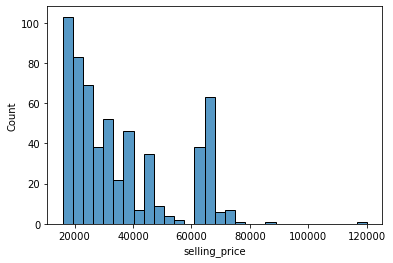

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=selling_price_outliers, x='selling_price',bins=30)

plt.show()

In [27]:
selling_price_outliers[selling_price_outliers.selling_price>60000].shape

(117, 12)

Thus, most of the outliers are actually reasonable values, while some of them are indeed quite high. We will drop these 100+ very high values.

In [28]:
df.drop(df[df.selling_price>60000].index, inplace=True)

The last column we should check is max_power_bhp.

In [29]:
max_power_bhp_outliers = find_outliers(df,'max_power_bhp')
max_power_bhp_outliers.describe()

,year,selling_price,km_driven,mileage_kmpl,engine_CC,max_power_bhp,seats
count,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000,483.000000
mean,2015.519669,25176.819702,55572.908903,15.484948,2264.167702,176.540932,5.569358
std,3.154580,11705.374390,45117.132494,3.261763,387.230638,21.307199,0.933945
min,2004.000000,1200.000000,2000.000000,0.000000,1368.000000,149.500000,4.000000
25%,2014.000000,16560.000000,20000.000000,13.000000,1984.000000,163.450000,5.000000
50%,2017.000000,24000.000000,45000.000000,15.730000,1999.000000,174.500000,5.000000
75%,2018.000000,32532.000000,70000.000000,18.000000,2494.000000,187.400000,7.000000
max,2020.000000,55200.000000,330000.000000,23.300000,2999.000000,270.900000,8.000000


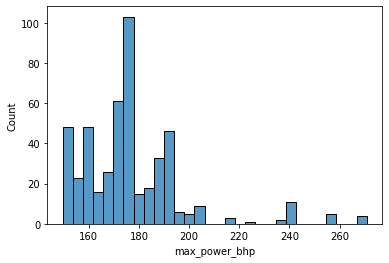

In [30]:
sns.histplot(data=max_power_bhp_outliers, x='max_power_bhp',bins=30)

plt.show()

Some values are indeed very high, but the majority of these data points seems fine. We will just drop a few very large values. 

In [31]:
max_power_bhp_outliers[max_power_bhp_outliers.max_power_bhp>210].shape

(26, 12)

In [32]:
df.drop(df[df.max_power_bhp>210].index, inplace=True)

Finally, let's check how many outliers we have left in the other columns. 

In [33]:
for column in ['year','km_driven','mileage_kmpl']:
    print(f'{column} number of outliers =',find_outliers_less_strict(df,column).shape[0])
print('df size =',df.shape)

year number of outliers = 58
km_driven number of outliers = 79
mileage_kmpl number of outliers = 17
df size = (7663, 12)


The remaining outliers are a small fraction of the data points, so we may just drop them. 

In [34]:
for column in ['year','km_driven','mileage_kmpl']:
    df.drop(find_outliers(df,column).index, inplace=True)

In [35]:
df.shape

(7303, 12)

We can now focus on the discrete variables.

### Exploring the Discrete Variables 

In [36]:
df.describe(include='object')

,name,fuel,seller_type,transmission,owner
count,7303,7303,7303,7303,7303
unique,1843,2,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,129,3997,6086,6429,4903


All columns contain just a few unique values except for name. We could use this column to make a new variable containing the brand, such as Maruti rather than Maruti Swift Dzire VDI. Unfortunately, this would still probably leave us with dozens of unique values that would need to be hot-encoded. This would complicate our model a lot.

In [37]:
df['name'].str.split().str[0].unique().shape[0]

27

In [38]:
df['name'].str.split().str[0].value_counts()

Maruti           2167
Hyundai          1310
Mahindra          718
Tata              685
Honda             455
Toyota            390
Ford              372
Renault           224
Chevrolet         219
Volkswagen        180
Skoda             100
Nissan             80
Jaguar             67
Datsun             65
Volvo              64
Mercedes-Benz      40
BMW                40
Fiat               40
Audi               27
Jeep               25
Mitsubishi         10
Force               6
Land                5
Isuzu               5
Kia                 4
MG                  3
Ambassador          2
Name: name, dtype: int64

Indeed, there are 27 car brands in this data set and, while the majority of data points belongs to only 10 brands or so, we still think it is not worth to complicate the model too much. In the future we might decide to use the information included in the name column, but for now we will just drop it. 

In [39]:
df.drop('name',axis=1,inplace=True)

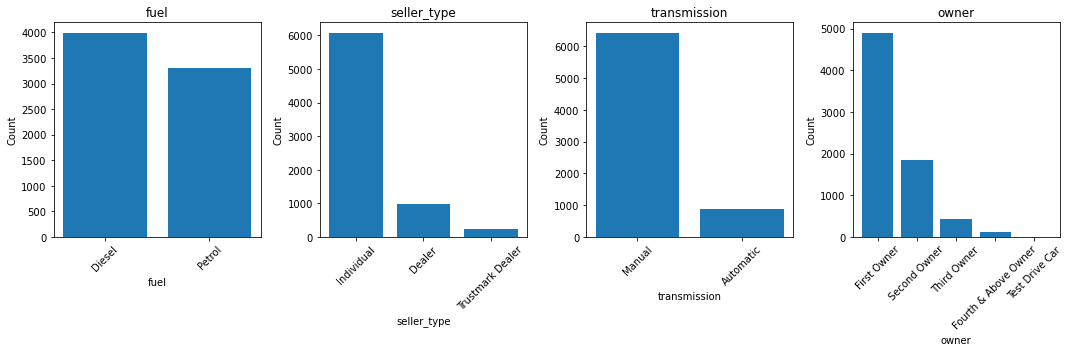

In [40]:
columns_to_plot = ['fuel', 'seller_type', 'transmission', 'owner']

fig, axs = plt.subplots(1, len(columns_to_plot), figsize=(15, 5))

for i, col in enumerate(columns_to_plot):
    value_counts = df[col].value_counts()
    axs[i].bar(value_counts.index, value_counts.values)
    axs[i].set_title(col)
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Count')
    plt.setp(axs[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

The fuel column is fairly balanced. 

The seller_type column is not. To simplify the model, we will merge Dealer and Trustmark Dealer into the same category, and then turn seller_type into a boolean variable.

The transmission column is not balanced and the vast majority of cars are manual.

The owner column is not balanced. If we drop the few data points that are Test Drive Car, we can turn this column into a numerical one, since the categories are ordered. Alternatively, since the vast majority of the owners are first owners, we could turn this variable into a boolean variable (first owner vs non first owner). For now, we will turn it into a numerical column. 

### Transforming the Discrete Variables

In [41]:
df['fuel_diesel'] = 1
df.loc[df[df.fuel=='Petrol'].index,'fuel_diesel']=0
df[['fuel_diesel','fuel']].head()

,fuel_diesel,fuel
0,1,Diesel
1,1,Diesel
2,0,Petrol
3,1,Diesel
4,0,Petrol


In [42]:
df.drop('fuel',axis=1,inplace=True)

In [43]:
df['seller_type_individual']=1
df.loc[df[df.seller_type!='Individual'].index,'seller_type_individual']=0
df[['seller_type_individual']].value_counts()

seller_type_individual
1                         6086
0                         1217
dtype: int64

In [44]:
df.drop('seller_type',axis=1,inplace=True)

In [45]:
df['transmission_manual']=1
df.loc[df[df.transmission!='Manual'].index,'transmission_manual']=0
df[['transmission_manual']].value_counts()

transmission_manual
1                      6429
0                       874
dtype: int64

In [46]:
df.drop('transmission',axis=1,inplace=True)

In [47]:
df.drop(df[df.owner=='Test Drive Car'].index,inplace=True)

In [48]:
df.loc[df[df.owner=='First Owner'].index,'owner'] = 1
df.loc[df[df.owner=='Second Owner'].index,'owner'] = 2
df.loc[df[df.owner=='Third Owner'].index,'owner'] = 3
df.loc[df[df.owner=='Fourth & Above Owner'].index,'owner'] = 4
df['owner'] = df['owner'].astype(int)

In [776]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7301 entries, 0 to 8127
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    7301 non-null   int64  
 1   selling_price           7301 non-null   float64
 2   km_driven               7301 non-null   int64  
 3   owner                   7301 non-null   int32  
 4   mileage_kmpl            7301 non-null   float64
 5   engine_CC               7301 non-null   int32  
 6   max_power_bhp           7301 non-null   float64
 7   seats                   7301 non-null   float64
 8   fuel_diesel             7301 non-null   int64  
 9   seller_type_individual  7301 non-null   int64  
 10  transmission_manual     7301 non-null   int64  
dtypes: float64(4), int32(2), int64(5)
memory usage: 885.5 KB


### Checking Collinearity 

Since we want to make a linear model, we need to assess whether any variables are significantly correlated. 

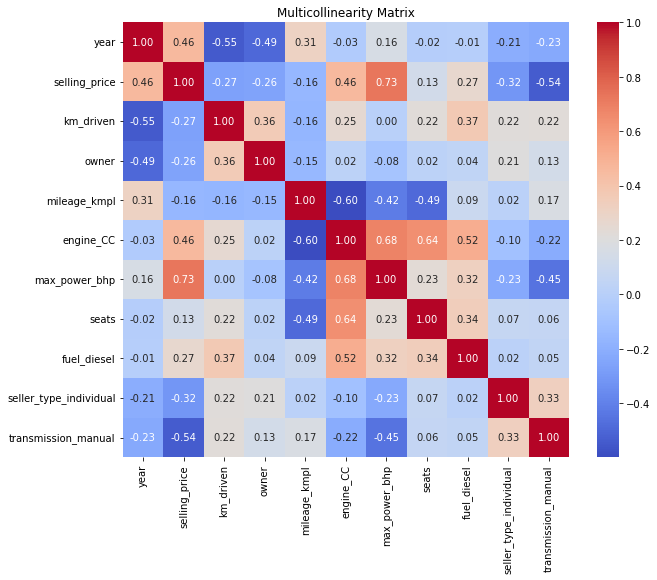

In [49]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Multicollinearity Matrix')
plt.show()

We see that engine_CC, max_power_bhp, and seats are highly correlated. This makes sense because the larger a car is, the more powerful it must be. Also, it is not surprising that engine_CC and max_power_bhp are highly correlated since they are both related to how powerful an engine is. We will have to take this into account when training the linear model. 

Since max_power_bhp is highly correlated with 'selling_price', we would like to keep this variable. Also, since 'engine_CC' is highly correlated with max_power_bhp, seats, mileage_kmpl, and fuel_diesel, it is likely that dropping it will not lead to a sharp decrease in performance or $R^2$.

Before fitting the model, let's plot the numerical variables.

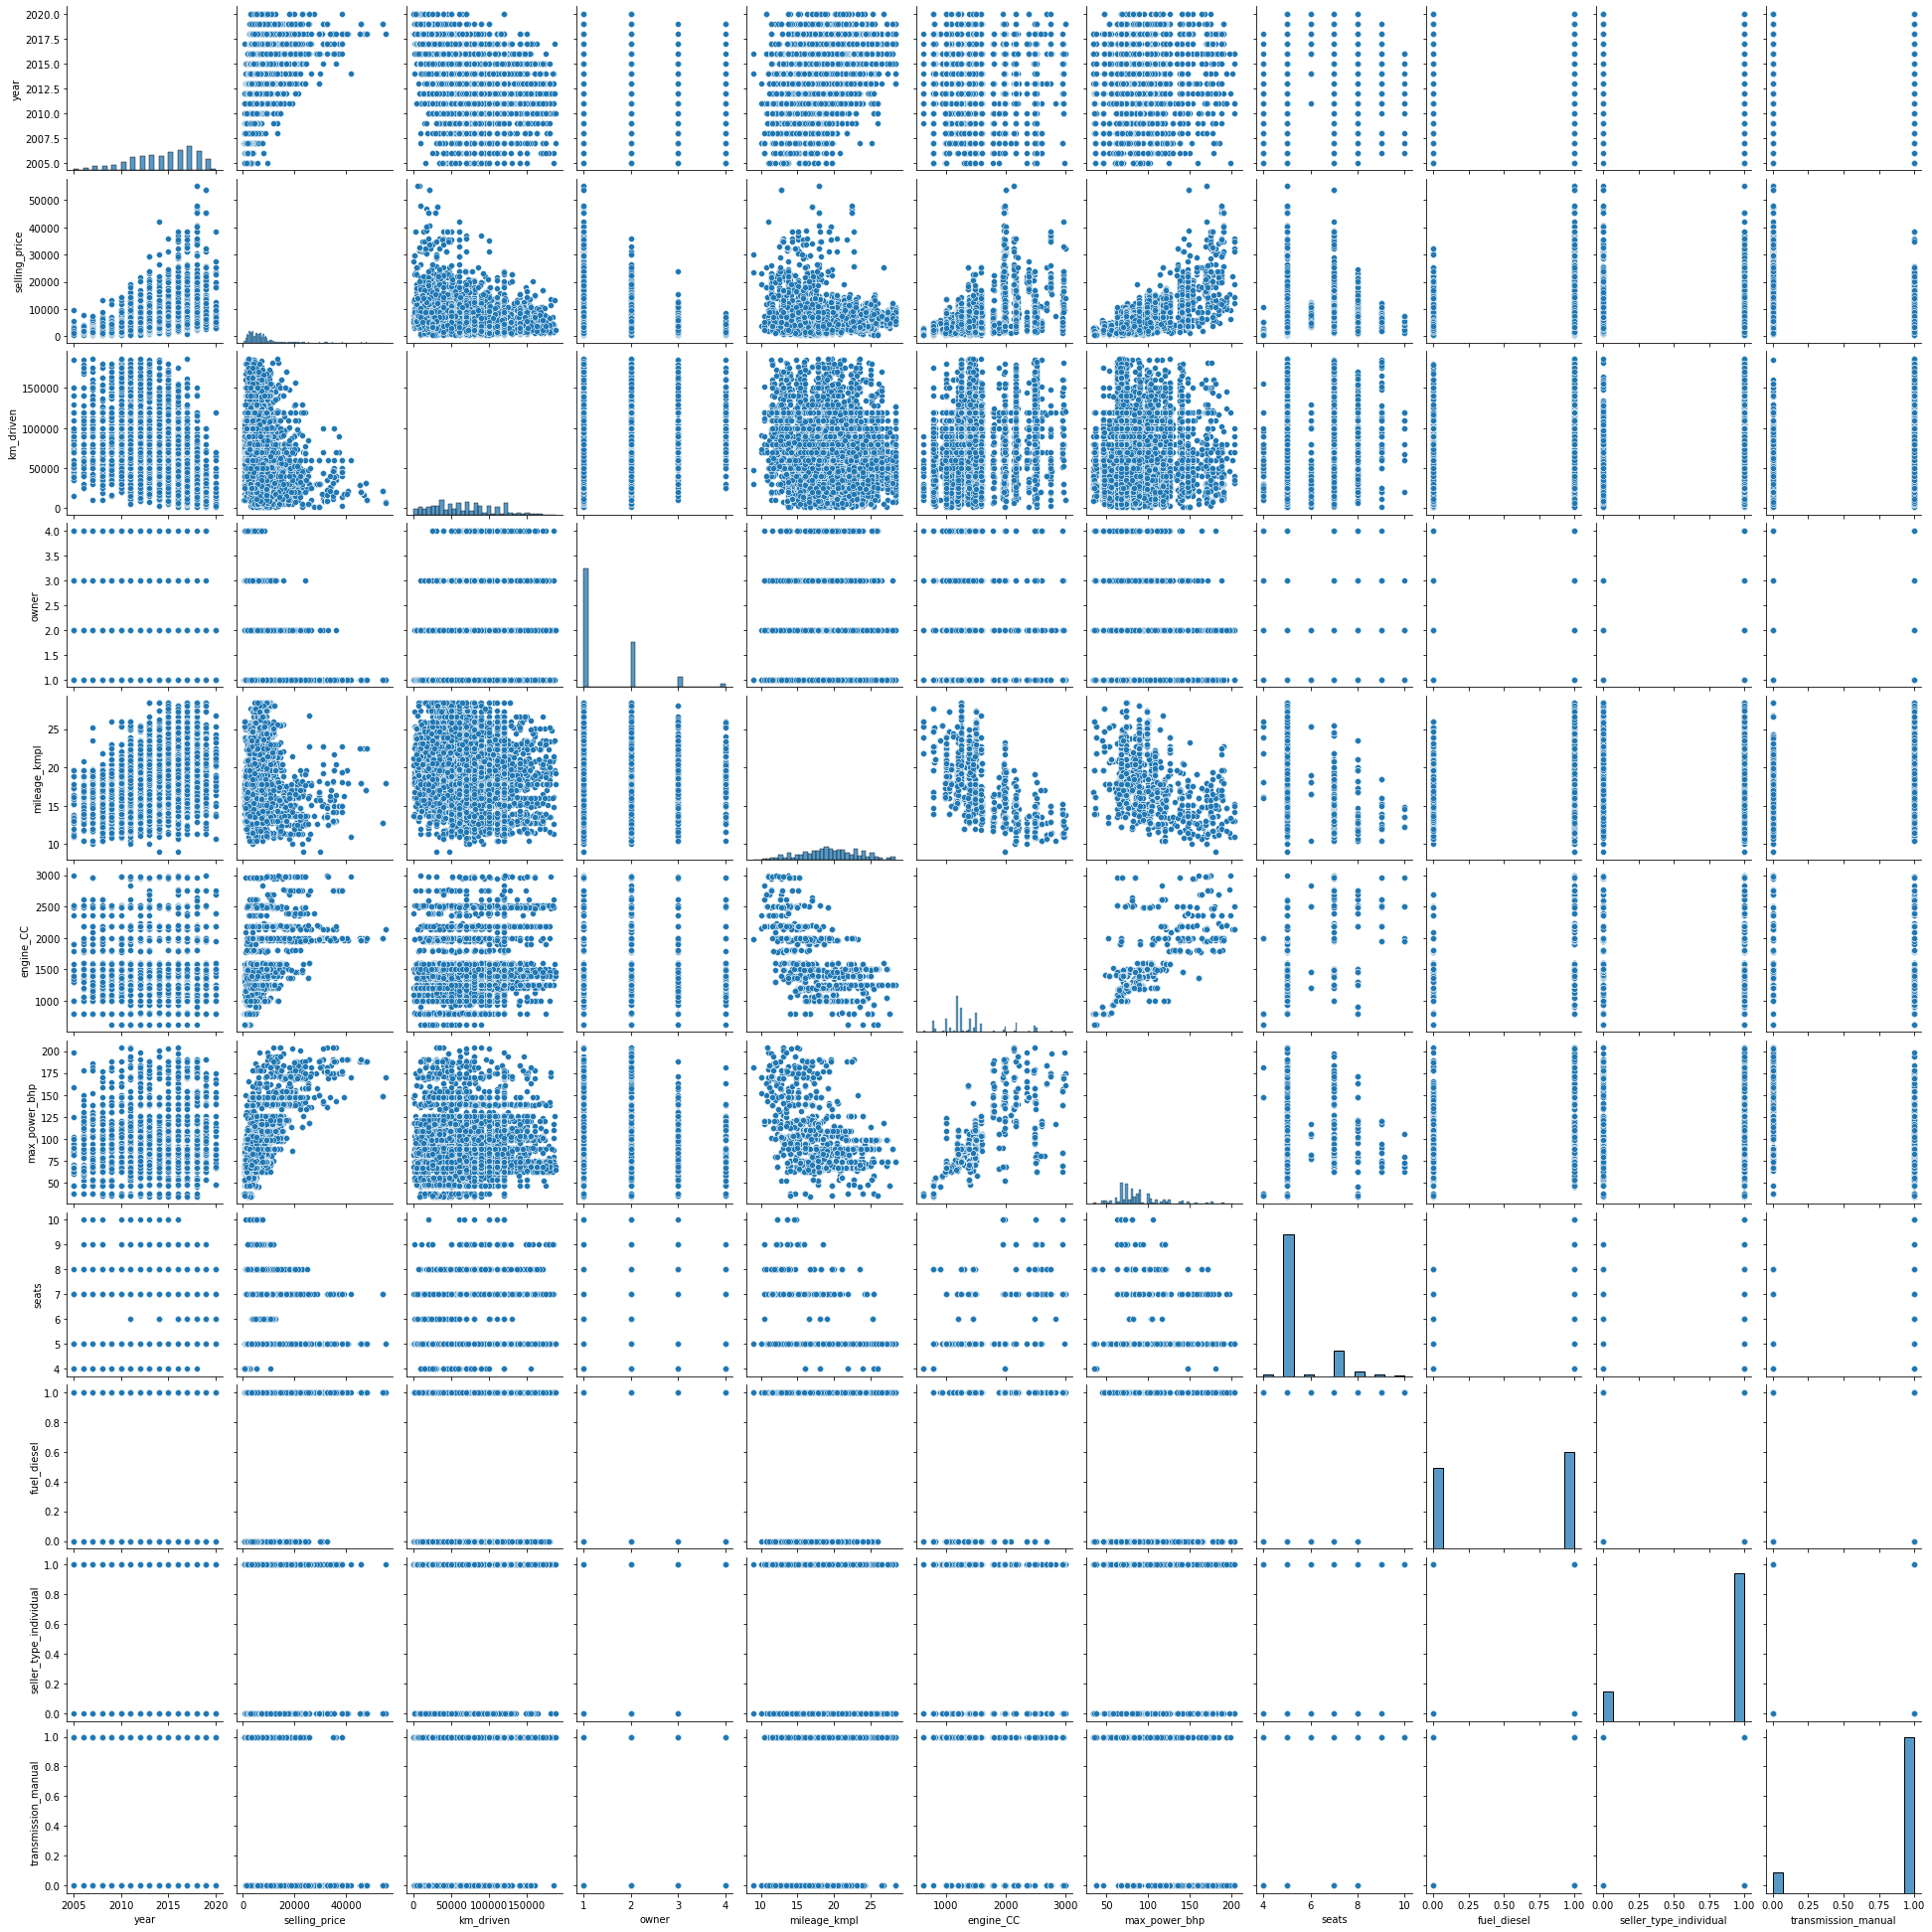

In [50]:
sns.pairplot(df)

plt.show()

The above plots show us that selling_price is definitely related to year, engine_CC, and max_power_bhp. Also, it is quite clear that engine_CC and max_power_bhp are proportional to each other.

# Linear Model

In [51]:
from sklearn.model_selection import train_test_split

X, y = df.drop('selling_price', axis=1), df.selling_price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [55]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

lr = sm.OLS(y_train, X_train).fit()

lr_pred = lr.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, lr_pred))
print('Root Mean Square Error:', rmse)

Root Mean Square Error: 3459.746070755581


C:\Users\Francesco\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [56]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          selling_price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     1366.
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:59:20   Log-Likelihood:                -56045.
No. Observations:                5840   AIC:                         1.121e+05
Df Residuals:                    5829   BIC:                         1.122e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -9.694e+05   4.12e+04    -23.532      0.000   -1.05e+06   -8.89e+05
year                     482.9213     20.568     23.480      0.000     442.601     523.242
km_driven                 -0.0219      0.002    -13.479      0.000      -0.025      -0.019
owner                   -193.1823     80.850     -2.389      0.017    -351.679     -34.686
mileage_kmpl             -30.3811     22.120     -1.373      0.170     -73.744      12.982
engine_CC                  0.4994      0.224      2.225      0.026       0.059       0.939
max_power_bhp            106.2331      2.524     42.090      0.000     101.285     111.181
seats                   -195.5292     75.978     -2.573      0.010    -344.475     -46.583
fuel_diesel             2065.0964    147.700     13.982      0.000    1775.550    2354.643
seller_type_individual  -848.0577    138.148     -6.139      0.000   -1118.879    -577.237
transmission_manual    -4097.7908    175.100    -23.403      0.000   -4441.053   -3754.529
==============================================================================
Omnibus:                     2945.035   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44422.885
Skew:                           2.044   Prob(JB):                         0.00
Kurtosis:                      15.878   Cond. No.                     6.71e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.71e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
y_test.describe()

count     1461.000000
mean      7132.514916
std       6614.439281
min        540.000000
25%       3360.000000
50%       5640.000000
75%       8280.000000
max      55200.000000
Name: selling_price, dtype: float64

Given that the median of y_test is 5.6k dollars, an RMSE of 3.5k dollars is quite bad. However, we have to remeber that the standard deviation is 6.6k dollars, meaning that there is a lot of variability in the data. Thus, while our predictions are not very accurate, the model is still somewhat useful. The fact that $R^2 = 0.7$ indicates that the model manages to explain a reasonably large proportion of the variability in the data. 

Let's not try to fit a second linear model without using engine_CC.

In [63]:
lr_without_engine_CC = sm.OLS(y_train, X_train.drop('engine_CC',axis=1)).fit()

lr_without_engine_CC_pred = lr_without_engine_CC.predict(X_test.drop('engine_CC',axis=1))

rmse = sqrt(mean_squared_error(y_test, lr_without_engine_CC_pred))
print('Root Mean Square Error:', rmse)

Root Mean Square Error: 3461.6629620860163


In [64]:
lr_without_engine_CC.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          selling_price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     1516.
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:10:37   Log-Likelihood:                -56047.
No. Observations:                5840   AIC:                         1.121e+05
Df Residuals:                    5830   BIC:                         1.122e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -9.739e+05   4.12e+04    -23.659      0.000   -1.05e+06   -8.93e+05
year                     485.3616     20.545     23.624      0.000     445.085     525.638
km_driven                 -0.0216      0.002    -13.329      0.000      -0.025      -0.018
owner                   -196.8598     80.861     -2.435      0.015    -355.377     -38.342
mileage_kmpl             -52.1012     19.856     -2.624      0.009     -91.026     -13.176
max_power_bhp            108.8796      2.227     48.893      0.000     104.514     113.245
seats                   -129.0063     69.873     -1.846      0.065    -265.983       7.970
fuel_diesel             2220.0465    130.297     17.038      0.000    1964.617    2475.476
seller_type_individual  -873.3273    137.727     -6.341      0.000   -1143.323    -603.332
transmission_manual    -4110.4793    175.067    -23.479      0.000   -4453.675   -3767.283
==============================================================================
Omnibus:                     2911.191   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42993.784
Skew:                           2.020   Prob(JB):                         0.00
Kurtosis:                      15.664   Cond. No.                     6.70e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.7e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The RMSE is essentially the same as before. However, the fact that also the value of $R^2$ has not changed indicates that engine_CC is indeed redundant since the information that this variable contains is mostly contained in other columns. 

We notice that p-value of seats is now slightly larger than 0.05. Let's check what happens when we remove seats.

In [65]:
lr_without_engine_CC_and_seats = sm.OLS(y_train, X_train.drop(['engine_CC','seats'],axis=1)).fit()

lr_without_engine_CC_and_seats_pred = lr_without_engine_CC_and_seats.predict(X_test.drop(['engine_CC','seats'],axis=1))

rmse = sqrt(mean_squared_error(y_test, lr_without_engine_CC_and_seats_pred))
print('Root Mean Square Error:', rmse)

Root Mean Square Error: 3462.2826810699657


In [66]:
lr_without_engine_CC_and_seats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          selling_price   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     1704.
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:21:18   Log-Likelihood:                -56049.
No. Observations:                5840   AIC:                         1.121e+05
Df Residuals:                    5831   BIC:                         1.122e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -9.523e+05   3.95e+04    -24.120      0.000   -1.03e+06   -8.75e+05
year                     474.1278     19.628     24.156      0.000     435.650     512.605
km_driven                 -0.0219      0.002    -13.572      0.000      -0.025      -0.019
owner                   -191.3768     80.823     -2.368      0.018    -349.820     -32.934
mileage_kmpl             -29.8080     15.766     -1.891      0.059     -60.715       1.099
max_power_bhp            109.6341      2.190     50.072      0.000     105.342     113.926
fuel_diesel             2116.5445    117.645     17.991      0.000    1885.917    2347.172
seller_type_individual  -886.1749    137.579     -6.441      0.000   -1155.882    -616.468
transmission_manual    -4152.2841    173.632    -23.914      0.000   -4492.668   -3811.900
==============================================================================
Omnibus:                     2914.016   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43168.047
Skew:                           2.021   Prob(JB):                         0.00
Kurtosis:                      15.691   Cond. No.                     6.43e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The RMSE and $R^2$ have not changed much, but now mileage_kmpl has a large p-value. We could try to drop mileage_kmpl, but we know that this variable is highly correlated with selling_price. Rather than doing this, we could try a more systematic approach like forward and backward selection. 

# Forward and Backward Selection

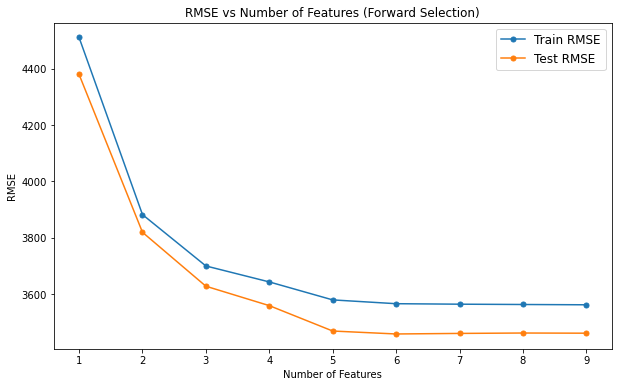

In [181]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from math import sqrt

n_features = X_train.drop('const',axis=1).shape[1]
rmse_values_forward_train = []  
rmse_values_forward_test = []  
models_forward = {}  
feature_names_forward = {}  

for i in range(1, n_features): 
    lr_forward = LinearRegression()  
    sfs = SequentialFeatureSelector(lr_forward, n_features_to_select=i, direction='forward')  
    sfs.fit(X_train.drop('const',axis=1), y_train)

    X_train_selected = sfs.transform(X_train.drop('const',axis=1))
    X_test_selected = sfs.transform(X_test.drop('const',axis=1)) 

    lr_forward.fit(X_train_selected, y_train) 
    
    model_name = 'lr_forward_' + str(i)  
    models_forward[model_name] = lr_forward  

    rmse_train = sqrt(mean_squared_error(y_train, lr_forward.predict(X_train_selected)))  
    rmse_test = sqrt(mean_squared_error(y_test, lr_forward.predict(X_test_selected)))  
    
    rmse_values_forward_train.append(rmse_train)
    rmse_values_forward_test.append(rmse_test)

    mask = sfs.get_support()  
    feature_names_forward[model_name] = X_train.drop('const',axis=1).columns[mask]  

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_features), rmse_values_forward_train, marker='o', linestyle='-', markersize=5, label='Train RMSE')  
plt.plot(range(1, n_features), rmse_values_forward_test, marker='o', linestyle='-', markersize=5, label='Test RMSE')  
plt.title('RMSE vs Number of Features (Forward Selection)')  
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.legend(fontsize='large')
plt.show()

The above graph indicates that the RMSE sharply decreases until the model has 5 features. After that, the RMSE remains stable. This means that only the first 5 variables added contain useful information. 

Let's now try backward selection. 

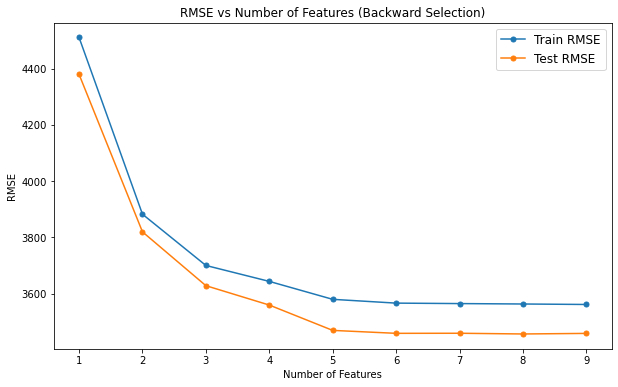

In [177]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
from math import sqrt

n_features = X_train.drop('const',axis=1).shape[1]
rmse_values_backward_train = []  
rmse_values_backward_test = []  
models_backward = {}  
feature_names_backward = {}  

for i in range(1, n_features): 
    lr_backward = LinearRegression()  
    sfs = SequentialFeatureSelector(lr_backward, n_features_to_select=i, direction='backward')  
    sfs.fit(X_train.drop('const',axis=1), y_train)

    X_train_selected = sfs.transform(X_train.drop('const',axis=1))
    X_test_selected = sfs.transform(X_test.drop('const',axis=1)) 

    lr_backward.fit(X_train_selected, y_train) 
    
    model_name = 'lr_backward_' + str(i)  
    models_backward[model_name] = lr_backward  

    rmse_train = sqrt(mean_squared_error(y_train, lr_backward.predict(X_train_selected)))  
    rmse_test = sqrt(mean_squared_error(y_test, lr_backward.predict(X_test_selected)))  
    
    rmse_values_backward_train.append(rmse_train)
    rmse_values_backward_test.append(rmse_test)

    mask = sfs.get_support()  
    feature_names_backward[model_name] = X_train.drop('const',axis=1).columns[mask]  

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_features), rmse_values_backward_train, marker='o', linestyle='-', markersize=5, label='Train RMSE')  
plt.plot(range(1, n_features), rmse_values_backward_test, marker='o', linestyle='-', markersize=5, label='Test RMSE')  
plt.title('RMSE vs Number of Features (Backward Selection)')  
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.legend(fontsize='large')
plt.show()

The plot looks the same as before. Let's check whether the two models with 5 features selected the same variables. 

In [185]:
print('Forward: ', feature_names_forward['lr_forward_5'])
print('Backward: ', feature_names_backward['lr_backward_5'])

Forward:  Index(['year', 'km_driven', 'max_power_bhp', 'fuel_diesel',
       'transmission_manual'],
      dtype='object')
Backward:  Index(['year', 'km_driven', 'max_power_bhp', 'fuel_diesel',
       'transmission_manual'],
      dtype='object')


The features are exactly the same, and so the models are identical. Here's is a summary of these models.

In [202]:
selected_variables = ['year', 'km_driven', 'max_power_bhp', 'fuel_diesel', 'transmission_manual']
dropped_variables = X_train.columns.difference(selected_variables)
lr_5_features = models_forward['lr_forward_5']
RMSE_lr_5_features = rmse_values_forward_test[4]
RMSE_lr_5_features_train = rmse_values_forward_train[4]

feature_names = X_train.drop(dropped_variables,axis=1).columns
coefficients = lr_5_features.coef_

print('Intercept:', lr_5_features.intercept_)
for coef, feat in zip(coefficients, feature_names):
    print(f'{feat}: {coef}')

r_squared = lr_5_features.score(X_train.drop(dropped_variables,axis=1), y_train)
print('R-squared:', r_squared)
print('Train RMSE =',RMSE_lr_5_features_train)
print('Test RMSE =',RMSE_lr_5_features)

Intercept: -976445.1634904251
year: 485.3165594225385
km_driven: -0.023186721960103632
max_power_bhp: 113.01249591362254
fuel_diesel: 2051.5475069290487
transmission_manual: -4396.6048714621675
R-squared: 0.6977160087984235
Train RMSE = 3579.7462422646313
Test RMSE = 3469.343739433877


In [256]:
from pyplotlm import PyPlotLm

lr_5_features_summary = PyPlotLm(lr_5_features,X_train.drop(dropped_variables,axis=1).values, y_train.values,intercept=False)
lr_5_features_summary.summary()

Residuals:
        Min         1Q  Median        3Q        Max
-13298.2647 -1697.5789 -2.4459 1340.3300 32265.5204

Coefficients:
                 Estimate  Std. Error   t value Pr(>|t|)     
(Intercept)  -976445.1635  34886.7342  -27.9890   0.0000  ***
X0               485.3166     17.2957   28.0599   0.0000  ***
X1                -0.0232      0.0016  -14.4791   0.0000  ***
X2               113.0125      1.8614   60.7139   0.0000  ***
X3              2051.5475    111.6938   18.3676   0.0000  ***
X4             -4396.6049    170.2592  -25.8230   0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3581.587 on 5834 degrees of freedom
Multiple R-squared: 0.6977,     Adjusted R-squared: 0.6975
F-statistic: 2693.15 on 5 and 5834 DF,  p-value: 1.11e-16


In addition, using the information feature_names_forward, we can see the order in which each feature was added. Here's the summary:
1. max_power_bhp
2. year
3. transmission_manual
4. fuel_diesel
5. km_driven

The fact that max_power_bhp was the first feature added is not surprising. In fact, this is the feature that had the largest correlation with selling_price. Next, we have year and transmission_manual. It makes sense that these features were selected because they also have a fairly strong correlation with the target. Finally, we have fuel_diesel and km_driven. As we can see from the above plots, these features improved the RMSE much less than the other features did. This is mostly due to the fact that their correlation with the target is not too high, and the fact that both features are correlated to other features that have already been selected. For example, there is a fairly large correlation between km_driven and year. 

For clarity, let's obtain the same model in statsmodels.

In [205]:
lr_5 = sm.OLS(y_train, X_train.drop(['engine_CC', 'mileage_kmpl', 'owner', 'seats',
       'seller_type_individual'],axis=1)).fit()

lr_5_pred = lr_5.predict(X_test.drop(['engine_CC', 'mileage_kmpl', 'owner', 'seats',
       'seller_type_individual'],axis=1))

rmse = sqrt(mean_squared_error(y_test, lr_5_pred))
print('Root Mean Square Error:', rmse)

Root Mean Square Error: 3469.343739433834


In [207]:
lr_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          selling_price   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     2693.
Date:                Fri, 13 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:35:02   Log-Likelihood:                -56076.
No. Observations:                5840   AIC:                         1.122e+05
Df Residuals:                    5834   BIC:                         1.122e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -9.764e+05   3.49e+04    -27.989      0.000   -1.04e+06   -9.08e+05
year                  485.3166     17.296     28.060      0.000     451.411     519.223
km_driven              -0.0232      0.002    -14.479      0.000      -0.026      -0.020
max_power_bhp         113.0125      1.861     60.714      0.000     109.363     116.662
fuel_diesel          2051.5475    111.694     18.368      0.000    1832.586    2270.509
transmission_manual -4396.6049    170.259    -25.823      0.000   -4730.376   -4062.834
==============================================================================
Omnibus:                     2867.768   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41751.674
Skew:                           1.984   Prob(JB):                         0.00
Kurtosis:                      15.483   Cond. No.                     5.66e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.66e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

While RMSE and the $R^2$ of this model is very similar to the ones of the models we previously obtained using more variables, the great advantage of this model is its simplicity. In fact, it only contains 5 features and, since it is a linear model, their effect is easy to quantify. For example, the model tells us that for each year increase, the price of the car increases by almost 500 dollars. Also, if the fuel a car uses is diesel rather than petrol, its price increases by a bit over 2k dollars. 

The main drawback of this model is that the RMSE is quite high, meaning that the predictions are not accurate. This is not a problem that can be solved by selecting more features or by regularizng the model. The issue is that the data itself is not quite linear. 

# Second Order Terms

In an attempt to capture the nonlinear patterns in the data, we will now add second order terms. Some of these terms will be the squared of the variables, like (max_power_bhp)^2. Others, will be interaction terms such as (max_power_bhp)*(year).

We should be careful with boolean variables since, for example, (fuel_diesel)^2 = fuel_diesel. 

In [315]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train.drop('const',axis=1))
X_train_poly = pd.DataFrame(X_train_poly, columns=poly.get_feature_names(X_train.drop('const',axis=1).columns))


X_test_poly = poly.transform(X_test.drop('const',axis=1))
X_test_poly = pd.DataFrame(X_test_poly, columns=poly.get_feature_names(X_test.drop('const',axis=1).columns))

In [317]:
columns_to_omit = ['fuel_diesel^2', 'transmission_manual^2', 'seller_type_individual^2']
X_train_poly.drop(columns_to_omit,axis=1,inplace=True)
X_test_poly.drop(columns_to_omit,axis=1,inplace=True)

In [318]:
X_train_poly.shape[1]

62

We now have 62 columns rather than 10. 

In [319]:
poly_reg = LinearRegression()

poly_reg.fit(X_train_poly, y_train)

poly_reg_pred = poly_reg.predict(X_test_poly)

rmse = sqrt(mean_squared_error(y_test, poly_reg_pred))
r_squared = poly_reg.score(X_test_poly, y_test)

print('R-squared:', r_squared)
print('Root Mean Square Error:', rmse)

R-squared: 0.8974821818170504
Root Mean Square Error: 2117.11296357182


We see great improvements in both $R^2$ and the RMSE. This is expected, but the problem with this model is that it is very difficult to interpret, since it contains 62+1 parameters, and it is not a straight line. Of course, it is highly likely that only a subset of the 62 variables is actually useful. Let's try to obtain a simpler model.

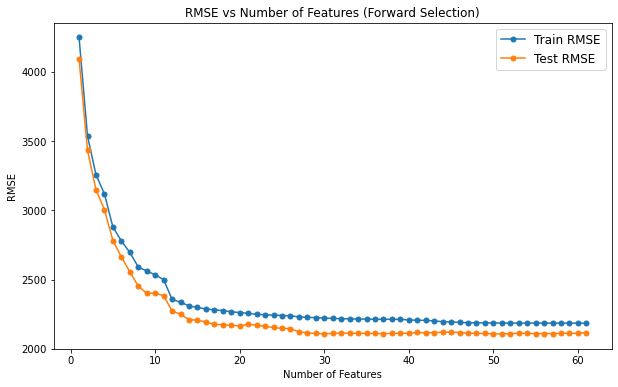

In [339]:
n_features = X_train_poly.shape[1]
rmse_values_forward_poly_train = []  
rmse_values_forward_poly_test = []  
models_forward_poly = {}  
feature_names_forward_poly = {}  

for i in range(1, n_features): 
    poly_reg = LinearRegression(n_jobs=-1)
    sfs = SequentialFeatureSelector(poly_reg, n_features_to_select=i, direction='forward')  
    sfs.fit(X_train_poly, y_train)

    X_train_selected = sfs.transform(X_train_poly)
    X_test_selected = sfs.transform(X_test_poly) 

    poly_reg.fit(X_train_selected, y_train) 
    
    model_name = 'poly_reg_forward_poly_' + str(i)  
    models_forward_poly[model_name] = poly_reg  

    rmse_train = sqrt(mean_squared_error(y_train, poly_reg.predict(X_train_selected)))  
    rmse_test = sqrt(mean_squared_error(y_test, poly_reg.predict(X_test_selected)))  
    
    rmse_values_forward_poly_train.append(rmse_train)
    rmse_values_forward_poly_test.append(rmse_test)

    mask = sfs.get_support()  
    feature_names_forward_poly[model_name] = X_train_poly.columns[mask]  

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_features), rmse_values_forward_poly_train, marker='o', linestyle='-', markersize=5, label='Train RMSE')  
plt.plot(range(1, n_features), rmse_values_forward_poly_test, marker='o', linestyle='-', markersize=5, label='Test RMSE')  
plt.title('RMSE vs Number of Features (Forward Selection)')  
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.legend(fontsize='large')
plt.show()

The above plot shows us that many of the 60+ variables we have are not that useful. However, differently from before, we see that up until we have 9 variables, the RMSE significantly improve, then it remain stable, and when we add the 13th feature it decreases again, before reaching a plateau. Let's compare these two models.

In [343]:
selected_variables = feature_names_forward_poly['poly_reg_forward_poly_9']
dropped_variables = X_train_poly.columns.difference(selected_variables)
poly_reg_forward_9_features = models_forward_poly['poly_reg_forward_poly_9']
RMSE_train_poly_reg_forward_9_features = rmse_values_forward_poly_train[8]
RMSE_test_poly_reg_forward_9_features = rmse_values_forward_poly_test[8]

feature_names = X_train_poly.drop(dropped_variables,axis=1).columns
coefficients = poly_reg_forward_9_features.coef_

print('Intercept:', poly_reg_forward_9_features.intercept_)
for coef, feat in zip(coefficients, feature_names):
    print(f'{feat}: {coef}')

r_squared = poly_reg_forward_9_features.score(X_train_poly[selected_variables], y_train)
print('R-squared:', r_squared)
print('Train RMSE =',RMSE_train_poly_reg_forward_9_features)
print('Test RMSE =',RMSE_test_poly_reg_forward_9_features)

Intercept: -1494440.1875014652
km_driven: 0.0636200208890277
transmission_manual: 1947175.712209127
year^2: 0.3669099690213155
year transmission_manual: -962.9467517265754
km_driven max_power_bhp: -0.0008546803448064266
mileage_kmpl engine_CC: 0.09677926400231228
max_power_bhp^2: 0.9769401827414465
max_power_bhp fuel_diesel: 12.05472977238914
max_power_bhp transmission_manual: -71.23671368760569
R-squared: 0.8452014123207893
Train RMSE = 2561.6993907965225
Test RMSE = 2400.803896148146


In [346]:
selected_variables = feature_names_forward_poly['poly_reg_forward_poly_12']
dropped_variables = X_train_poly.columns.difference(selected_variables)
poly_reg_forward_12_features = models_forward_poly['poly_reg_forward_poly_12']
RMSE_train_poly_reg_forward_12_features = rmse_values_forward_poly_train[11]
RMSE_test_poly_reg_forward_12_features = rmse_values_forward_poly_test[11]

feature_names = X_train_poly.drop(dropped_variables,axis=1).columns
coefficients = poly_reg_forward_12_features.coef_

print('Intercept:', poly_reg_forward_12_features.intercept_)
for coef, feat in zip(coefficients, feature_names):
    print(f'{feat}: {coef}')

r_squared = poly_reg_forward_12_features.score(X_train_poly[selected_variables], y_train)
print('R-squared:', r_squared)
print('Train RMSE =',RMSE_train_poly_reg_forward_12_features)
print('Test RMSE =',RMSE_test_poly_reg_forward_12_features)

Intercept: -248997.67624084713
km_driven: 0.028918796727651908
max_power_bhp: -21993.473511361575
transmission_manual: 1331775.4218482333
year^2: 0.05870381921659396
year max_power_bhp: 10.977652068663103
year transmission_manual: -656.3742067158315
km_driven max_power_bhp: -0.00042996711169929864
owner fuel_diesel: -514.174046538905
mileage_kmpl engine_CC: 0.08792196193277063
max_power_bhp^2: 0.37012854280886026
max_power_bhp fuel_diesel: 18.015326731887853
max_power_bhp transmission_manual: -98.07162430094904
R-squared: 0.8689613003765595
Train RMSE = 2356.9179031351878
Test RMSE = 2273.5157838516743


Clearly, the model with more variables is better in terms of RMSE and $R^2$, however this difference is not too large. The advantage of the model with 9 variables is that it is simpler, but neither model is too simple. Thus, also this difference is negligible. Here's the order in which the variables were selected:
1. max_power_bhp^2
2. year^2
3. max_power_bhp transmission_manual
4. transmission_manual
5. year transmission_manual
6. mileage_kmpl engine_CC
7. km_driven max_power_bhp
8. km_driven
9. max_power_bhp fuel_diesel
10. owner fuel_diesel
11. year max_power_bhp
12. max_power_bhp

We see that the first variables that were selected are max_power_bhp^2 and year^2. This is further evidence that these variables are very important to predict the target. In addition, this also confirms that nonlinear effects are very important to accurately predict selling_price. 

Let's now perform backward selection.

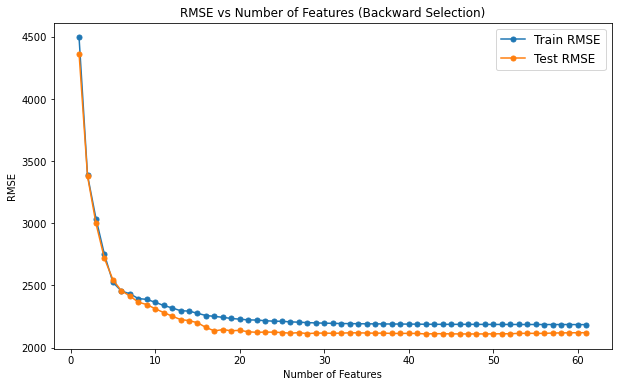

In [ ]:
n_features = X_train_poly.shape[1]
rmse_values_backward_poly_train = []  
rmse_values_backward_poly_test = []  
models_backward_poly = {}  
feature_names_backward_poly = {}  

for i in range(1, n_features): 
    poly_reg = LinearRegression(n_jobs=-1)
    sfs = SequentialFeatureSelector(poly_reg, n_features_to_select=i, direction='backward')  
    sfs.fit(X_train_poly, y_train)

    X_train_selected = sfs.transform(X_train_poly)
    X_test_selected = sfs.transform(X_test_poly) 

    poly_reg.fit(X_train_selected, y_train) 
    
    model_name = 'poly_reg_backward_poly_' + str(i)  
    models_backward_poly[model_name] = poly_reg  

    rmse_train = sqrt(mean_squared_error(y_train, poly_reg.predict(X_train_selected)))  
    rmse_test = sqrt(mean_squared_error(y_test, poly_reg.predict(X_test_selected)))  
    
    rmse_values_backward_poly_train.append(rmse_train)
    rmse_values_backward_poly_test.append(rmse_test)

    mask = sfs.get_support()  
    feature_names_backward_poly[model_name] = X_train_poly.columns[mask]  

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_features), rmse_values_backward_poly_train, marker='o', linestyle='-', markersize=5, label='Train RMSE')  
plt.plot(range(1, n_features), rmse_values_backward_poly_test, marker='o', linestyle='-', markersize=5, label='Test RMSE')  
plt.title('RMSE vs Number of Features (Backward Selection)')  
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.legend(fontsize='large')
plt.show()

In [369]:
selected_variables = feature_names_backward_poly['poly_reg_backward_poly_5']
dropped_variables = X_train_poly.columns.difference(selected_variables)
poly_reg_backward_5_features = models_backward_poly['poly_reg_backward_poly_5']
RMSE_train_poly_reg_backward_5_features = rmse_values_backward_poly_train[4]
RMSE_test_poly_reg_backward_5_features = rmse_values_backward_poly_test[4]

feature_names = X_train_poly.drop(dropped_variables,axis=1).columns
coefficients = poly_reg_backward_5_features.coef_

print('Intercept:', poly_reg_backward_5_features.intercept_)
for coef, feat in zip(coefficients, feature_names):
    print(f'{feat}: {coef}')

r_squared = poly_reg_backward_5_features.score(X_train_poly[selected_variables], y_train)
print('R-squared:', r_squared)
print('Train RMSE =',RMSE_train_poly_reg_backward_5_features)
print('Test RMSE =',RMSE_test_poly_reg_backward_5_features)

Intercept: -15100.29353766925
max_power_bhp: -30289.934277131128
transmission_manual: 1382342.9278160513
year max_power_bhp: 15.146723982776848
year transmission_manual: -679.6470593062664
max_power_bhp transmission_manual: -131.21479080009755
R-squared: 0.8496097930182285
Train RMSE = 2524.959674516569
Test RMSE = 2546.1362114395038


Using backward selection, we obtained a completely different model. This is the inverse order in which the features were eliminated: 
1. year max_power_bhp
2. max_power_bhp
3. max_power_bhp transmission_manual
4. transmission_manual
5. year transmission_manual

This model performs slightly worse than the ones we obtained using forward selection, but it is much simpler. In fact, its variables are combinations of max_power_bhp, year, and transmission_manual. This confirms that these 3 variables are very important to predict the target. In addition, we know from earlier models that also fuel_diesel and km_driven are useful to predict the target, but they don't seem to be as important since this model makes reasonable predictions without using them.

It is interesting to see that interaction terms are still important but there are no squared terms. We checked when the squared terms were eliminated by backward selection and we found that this happened very early in the process of feature selection. 

Let's use what we've learned so far to build a model that contains terms up to second order.

In [527]:
custom_reg = LinearRegression()
columns_to_use = ['year max_power_bhp','max_power_bhp','max_power_bhp transmission_manual','transmission_manual','year transmission_manual',
                 'km_driven','max_power_bhp fuel_diesel']

custom_reg.fit(X_train_poly[columns_to_use], y_train)

y_pred_test = custom_reg.predict(X_test_poly[columns_to_use])
y_pred_train = custom_reg.predict(X_train_poly[columns_to_use])

coefficients = custom_reg.coef_

print('Intercept:', custom_reg.intercept_)
for coef, feat in zip(coefficients, columns_to_use):
    print(f'{feat}: {coef}')

print('Train RMSE: %.2f' % sqrt(mean_squared_error(y_train, y_pred_train)))
print('Test RMSE: %.2f' % sqrt(mean_squared_error(y_test, y_pred_test)))

print('Coefficient of determination R^2: %.3f' % custom_reg.score(X_train_poly[columns_to_use], y_train))

Intercept: -12766.167773816635
year max_power_bhp: 14.314469390061323
max_power_bhp: -28637.39307561271
max_power_bhp transmission_manual: -126.53532033442214
transmission_manual: 1349793.5244739058
year transmission_manual: -663.9542280782719
km_driven: -0.009826618094461942
max_power_bhp fuel_diesel: 17.398923073842887
Train RMSE: 2436.40
Test RMSE: 2377.50
Coefficient of determination R^2: 0.860


After trying multiple combinations of the features selected by our previous models, we found that this is one of the best combinations in terms of performance and interpretability. Here's an equation for the model:

$ \text{selling_price} = \beta_0 + \text{max_power_bhp} \, (\beta_1 \, \text{year} + \beta_2 + \beta_3 \, \text{transmission_manual} + \beta_7 \,\text{fuel_diesel}) + \text{transmission_manual} \, (\beta_4 + \beta_5 \, \text{year}) + \beta_6 \, \text{km_driven}$

This model is telling us that the effect of max_power_bhp and transmission_manual is affected by other variables. There is also an interaction between these two variables. On the contrary, km_driven is just a linear contribution and it does not interact with any other variables. If we fix year, transmission_manual, and fuel_diesel, we can interpret this model as a straight line. Also, rather than constraining year to one single value, we could select a narrow range and approximate the above equation to a straight line. 

Let's check the t-values of all parameters.

In [491]:
custom_reg_summary = PyPlotLm(custom_reg,X_train_poly[columns_to_use].values, y_train.values,intercept=False)
custom_reg_summary.summary()

Residuals:
        Min         1Q   Median       3Q        Max
-18701.2357 -1068.9585 -63.1547 996.7555 25309.3489

Coefficients:
                 Estimate  Std. Error   t value Pr(>|t|)     
(Intercept)   -12766.1678    318.5750  -40.0727   0.0000  ***
X0                14.3145      0.2173   65.8738   0.0000  ***
X1            -28637.3931    437.6706  -65.4314   0.0000  ***
X2              -126.5353      2.6151  -48.3866   0.0000  ***
X3           1349793.5245  40511.4852   33.3188   0.0000  ***
X4              -663.9542     20.1043  -33.0255   0.0000  ***
X5                -0.0098      0.0011   -9.0926   0.0000  ***
X6                17.3989      0.8399   20.7146   0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2438.075 on 5832 degrees of freedom
Multiple R-squared: 0.8600,     Adjusted R-squared: 0.8598
F-statistic: 5116.76 on 7 and 5832 DF,  p-value: 1.11e-16


Nothing seems too concerning in these t-values but we notice that, while most residuals are reasonable, some are extremely high. This indicates that our RMSE score is potentially severely affected by extremely high values. We will investigate this further later in this section. 

In [425]:
X_test['year'].describe()

count    1461.000000
mean     2014.366188
std         3.349411
min      2005.000000
25%      2012.000000
50%      2015.000000
75%      2017.000000
max      2020.000000
Name: year, dtype: float64

Let's now approximate out model to a straight line in a subset of the data. For example, say that we take year to be $2014 \pm 2$, transmission_manual = 1, and fuel_diesel = 1. Then the model can be approximated to 

$ \text{selling_price} \approx (\beta_0+\beta_4 + \beta_5 \, 2014) + (\beta_1 \, 2014 + \beta_2 + \beta_3 + \beta_7) \,\text{max_power_bhp}+ \beta_6 \, \text{km_driven}$,

which is the equation of a line. Let's see how this model performs.

In [459]:
mask = (X_test.year>2012)&(X_test.year<2016)&(X_test.transmission_manual == 1)&(X_test.fuel_diesel == 1)

def custom_pred(row):
    return (-12766.167773816635+1349793.5244739058-(663.9542280782719*2014))+row['max_power_bhp']*((14.314469390061323*2014)-28637.39307561271-126.53532033442214+17.398923073842887)-0.009826618094461942*row['km_driven']

X_test_selected = X_test[['max_power_bhp','km_driven']]
y_pred_custom = X_test_selected[mask].apply(custom_pred,axis=1)
print('Test RMSE arroximated model: %.2f' % sqrt(mean_squared_error(y_test[mask], y_pred_custom)))

X_test_5_features = X_test[['year', 'km_driven', 'max_power_bhp', 'fuel_diesel', 'transmission_manual']]
print('Test RMSE linear model with 5 features: %.2f' % sqrt(mean_squared_error(y_test[mask], lr_5_features.predict(X_test_5_features[mask]))))

RMSE_new = sqrt(mean_squared_error(y_test[mask], y_pred_custom))
RMSE_old = sqrt(mean_squared_error(y_test[mask], lr_5_features.predict(X_test_5_features[mask])))
print('%% Improvement: %.2f' % (100*(RMSE_old-RMSE_new)/RMSE_old)+'%')

Test RMSE arroximated model: 2245.77
Test RMSE linear model with 5 features: 2594.97
% Improvement: 13.46%


Given how simple and easy to interpret the model is, it performs really well! In this region of the data (which is roughly 17% of the test data), it also performs significantly better than our old linear model with 5 features. 

In addition, we notice that the old linear model performed much better on this subset of data rather than on the original test set. This is not surprising, because we know that the target cannot be accurately described in a linear way, but if we consider a narrower region of the data, then the nonlinear effects become approximately negligible, and even a line can be used to describe the target. In this case, it happened that the subset of data we selected was described reasonably well by the linear model we had previously obtained. 

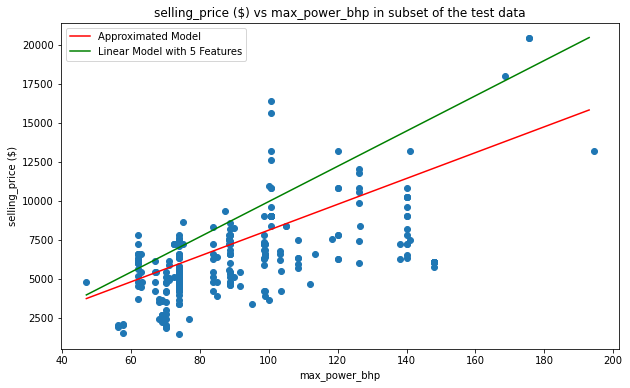

In [486]:
plt.figure(figsize=(10, 6))


plt.scatter(X_test.max_power_bhp[mask], y_test[mask])


x = range(int(min(X_test.max_power_bhp[mask])), int(max(X_test.max_power_bhp[mask])))
y = [(-12766.167773816635+1349793.5244739058-(663.9542280782719*2014))+i*((14.314469390061323*2014)-28637.39307561271-126.53532033442214+17.398923073842887) for i in x] 
plt.plot(x, y, label='Approximated Model', color='r')

y = [-976445.1634904251+i*113.01249591362254+2014*485.3165594225385+2051.5475069290487-4396.6048714621675 for i in x]  
plt.plot(x, y, label='Linear Model with 5 Features', color='g')

plt.xlabel('max_power_bhp')
plt.ylabel('selling_price ($)')
plt.title('selling_price ($) vs max_power_bhp in subset of the test data')
plt.legend()
plt.show()

From the above plot, we see that the approximated model fits most of the data much better. The models have a similar intercept, but the old linear model has a considerably higher slope. This is because this model was fitted on the whole data set, and selling_price vs max_power_bhp (considering all data points) seems to be quadratic rather than linear. Thus, in order to account for this, the old linear model needs a much higher slope.  

Let's now assess which data points are given very high residuals.

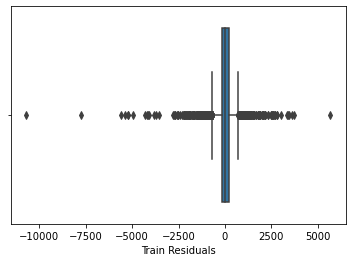

In [513]:
train_residuals = y_pred_train - y_train
sns.boxplot(x=train_residuals)
plt.xlabel('Train Residuals')
plt.show()

We see that we have quite a few outlier residuals and a few of them are extremely high. Let's isolate all outliers. 

In [504]:
Q1 = train_residuals.quantile(0.25)
Q3 = train_residuals.quantile(0.75)
IQR = Q3 - Q1

filter = (train_residuals >= Q1 - 1.5 * IQR) & (train_residuals <= Q3 + 1.5 *IQR)
train_residuals_outliers = train_residuals[~filter]

print('Train data points:',train_residuals.shape[0])
print('Number of outlier residuals:',train_residuals_outliers.shape[0])

Train data points: 5840
Nuber of outlier residuals: 527


We see that roughly 10% of the residuals are outliers.

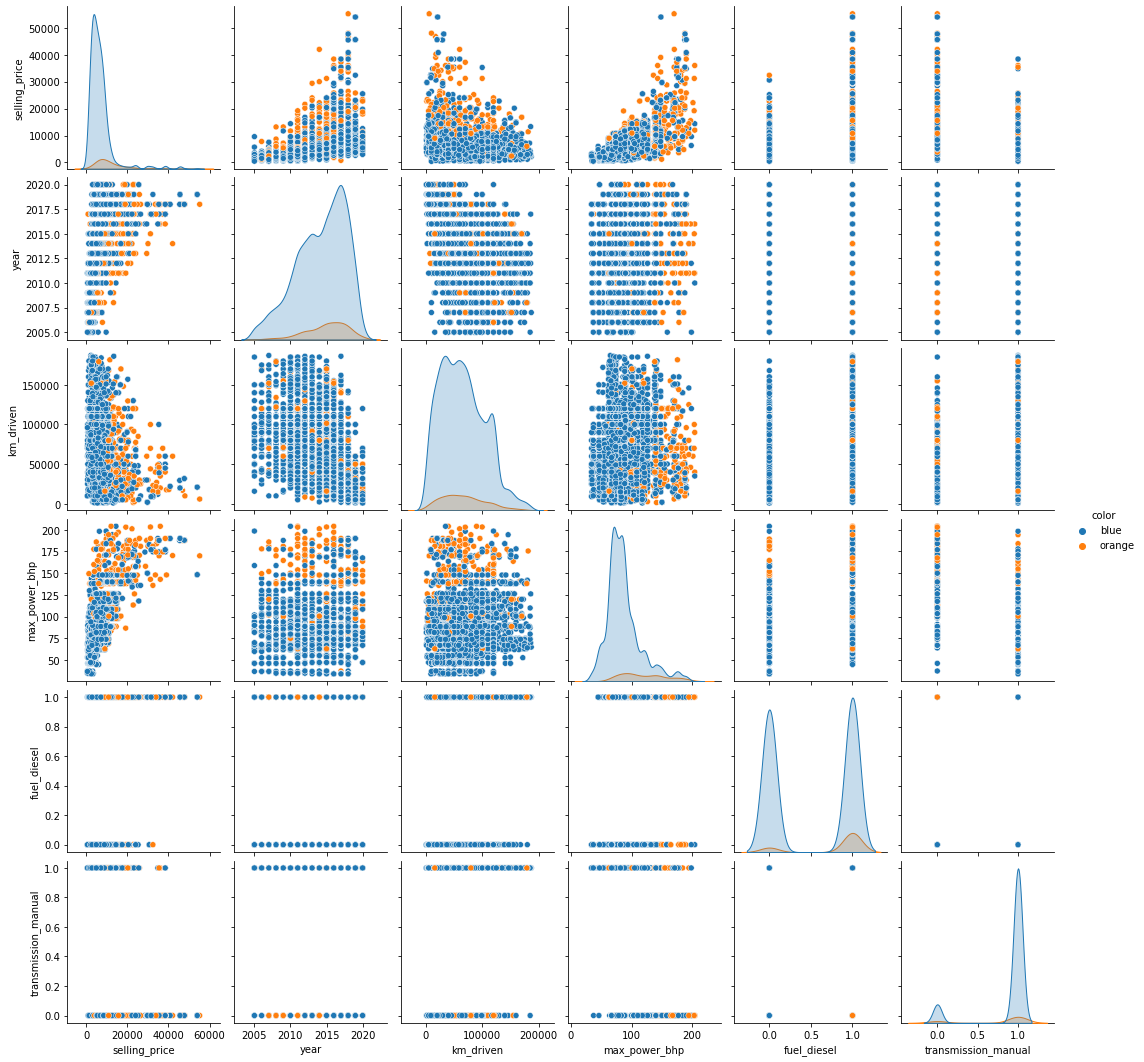

In [510]:
train_plot = df.loc[X_train.index,['selling_price','year', 'km_driven', 'max_power_bhp', 'fuel_diesel', 'transmission_manual']].copy()

train_plot['color'] = 'blue'
train_plot.loc[train_residuals_outliers.index,'color']='orange'


sns.pairplot(train_plot, hue='color')
plt.show()

In the above plots, the outlier residuals are in orange, while the non-outlier residuals are in blue. The plot of selling_price vs max_power_bhp clearly indicates that the outliers mostly happen for high values of max_power_bhp. This is confirmed by the distribution of max_power_bhp. This might indicate that our model is incomplete. Let's try to add max_power_bhp^2. 

In [512]:
custom_reg_new = LinearRegression()
columns_to_use_new = ['year max_power_bhp','max_power_bhp','max_power_bhp transmission_manual','transmission_manual','year transmission_manual',
                 'km_driven','max_power_bhp fuel_diesel','max_power_bhp^2']

custom_reg_new.fit(X_train_poly[columns_to_use_new], y_train)

y_pred_test_new = custom_reg_new.predict(X_test_poly[columns_to_use_new])
y_pred_train_new = custom_reg_new.predict(X_train_poly[columns_to_use_new])

coefficients_new = custom_reg_new.coef_

print('Intercept:', custom_reg_new.intercept_)
for coef, feat in zip(coefficients_new, columns_to_use_new):
    print(f'{feat}: {coef}')

print('Train RMSE: %.2f' % sqrt(mean_squared_error(y_train, y_pred_train_new)))
print('Test RMSE: %.2f' % sqrt(mean_squared_error(y_test, y_pred_test_new)))

print('Coefficient of determination R^2: %.3f' % custom_reg_new.score(X_train_poly[columns_to_use_new], y_train))

Intercept: -9670.062853423546
year max_power_bhp: 14.20241197099932
max_power_bhp: -28465.016351808732
max_power_bhp transmission_manual: -113.09903077715971
transmission_manual: 1307784.6327180706
year transmission_manual: -643.765043904381
km_driven: -0.009326802582285314
max_power_bhp fuel_diesel: 17.049406991982032
max_power_bhp^2: 0.20719125053327261
Train RMSE: 2428.17
Test RMSE: 2366.73
Coefficient of determination R^2: 0.861


There is no significant improvement from before, so there is no real advantage in adding max_power_bhp^2. 

We cannot simply eliminate all the data points with high residuals, but we can conclude that our model performs better for smaller values of max_power_bhp. 

Let's check what happens to the test RMSE if we eliminate the 2 data points with extremely large outliers.

In [529]:
indices = train_residuals.abs().nlargest(2).index
y_pred_train_df = pd.DataFrame(data=y_pred_train,index=y_train.index)
print('Train RMSE: %.2f' % sqrt(mean_squared_error(y_train.drop(indices), y_pred_train_df.drop(indices))))

Train RMSE: 2404.85


There was a small improvement but it is not significant. Thus, we can conclude that the train RMSE is not dramatically affected by these extreme residuals.

Let's explore how the train RMSE changes as we set a maximum threshold for max_power_bhp.

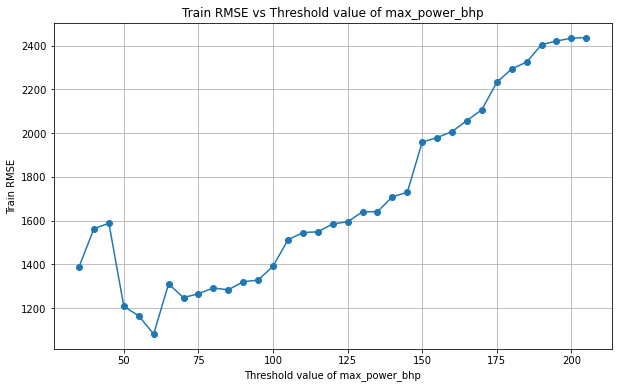

In [549]:
threshold_values = range(35, 210, 5)
rmse_values = []

for threshold in threshold_values:
    indices_small_max_power_bhp = X_train[X_train.max_power_bhp > threshold].index
    rmse = sqrt(mean_squared_error(y_train.drop(indices_small_max_power_bhp), y_pred_train_df.drop(indices_small_max_power_bhp)))
    rmse_values.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(threshold_values, rmse_values, marker='o')
plt.xlabel('Threshold value of max_power_bhp')
plt.ylabel('Train RMSE')
plt.title('Train RMSE vs Threshold value of max_power_bhp')
plt.grid(True)
plt.show()

After some initial fluctuations, the train RMSE starts to sharply increase at values around max_power_bhp = 100. This is not too bad since 100 is actually the 75th percentile of max_power_bhp in our cleaned data set.

In [548]:
indices_small_max_power_bhp = X_train[X_train.max_power_bhp>100].index
test_indices = X_test[X_test.max_power_bhp>100].index
y_pred_test_df = pd.DataFrame(data=y_pred_test,index=X_test.index)

print('Train RMSE: %.2f' % sqrt(mean_squared_error(y_train.drop(indices_small_max_power_bhp), y_pred_train_df.drop(indices_small_max_power_bhp))))
print('Test RMSE: %.2f' % sqrt(mean_squared_error(y_test.drop(test_indices), y_pred_test_df.drop(test_indices))))

Train RMSE: 1391.54
Test RMSE: 1440.86


Thus, if we apply our model to only 3/4 of our data by setting max_power_bhp = 100 as a threshold, then the RMSE is much smaller. 

In [551]:
indices_small_max_power_bhp = X_train[X_train.max_power_bhp<100].index
test_indices = X_test[X_test.max_power_bhp<100].index
y_pred_test_df = pd.DataFrame(data=y_pred_test,index=X_test.index)

print('Train RMSE: %.2f' % sqrt(mean_squared_error(y_train.drop(indices_small_max_power_bhp), y_pred_train_df.drop(indices_small_max_power_bhp))))
print('Test RMSE: %.2f' % sqrt(mean_squared_error(y_test.drop(test_indices), y_pred_test_df.drop(test_indices))))

Train RMSE: 4145.54
Test RMSE: 3900.54


However, if one wants to use this model to make predictions on data points that have max_power_bhp>100, then the quality of the predictions is very low. Unfortunately, if one wants one single model that can be interpreted and used to make predictions on the whole data set, there isn't much that can be done about this. In fact, one might try to add degree 3 terms, but this would very likely significantly complicate the model, and it might still not fix the issue. However, we might be able to fix this by training two different models on these two separate regions of the data set, as we will show in the next section.

### Training Two Models in Separate Regions of the Data Set

In the previous section, we produced a simple model with second order terms. We noticed that the RMSE is reasonable for data points with max_power_bhp < 100 (which is 75% of the data set) but it is very high for data points with max_power_bhp > 100. This is due to the fact that these two groups of data points behave in different ways, and so one single simple model is not appropriate to describe both of them. In an attempt to avoid including higher order terms in our model, we will now try to train the model we previously obtained in separate regions of the training data set.

First, let's separate the data.

In [554]:
X_train_poly_smaller_100 = X_train_poly[X_train_poly.max_power_bhp < 100]
X_test_poly_smaller_100 = X_test_poly[X_test_poly.max_power_bhp < 100]
y_train_smaller_100 = y_train.iloc[X_train_poly_smaller_100.index]
y_test_smaller_100 = y_test.iloc[X_test_poly_smaller_100.index]

X_train_poly_larger_100 = X_train_poly[X_train_poly.max_power_bhp >= 100]
X_test_poly_larger_100 = X_test_poly[X_test_poly.max_power_bhp >= 100]
y_train_larger_100 = y_train.iloc[X_train_poly_larger_100.index]
y_test_larger_100 = y_test.iloc[X_test_poly_larger_100.index]

X_train_smaller_100 = X_train[X_train.max_power_bhp < 100]
X_test_smaller_100 = X_test[X_test.max_power_bhp < 100]
X_train_larger_100 = X_train[X_train.max_power_bhp >= 100]
X_test_larger_100 = X_test[X_test.max_power_bhp >= 100]

X_train_smaller_100 = X_train_smaller_100.drop('const',axis=1)
X_test_smaller_100 = X_test_smaller_100.drop('const',axis=1)
X_train_larger_100 = X_train_larger_100.drop('const',axis=1)
X_test_larger_100 = X_test_larger_100.drop('const',axis=1)

To better contextualize the RMSE values that we obtained in the previous section, let's check how the target is distributed in these two regions of the data set.

In [788]:
y_test_smaller_100.describe()

count     1060.000000
mean      5022.562721
std       2618.399280
min        540.000000
25%       2970.000000
50%       4680.000000
75%       6900.000000
max      14400.000000
Name: selling_price, dtype: float64

In [789]:
y_test_larger_100.describe()

count      401.000000
mean     12709.944658
std       9927.543714
min       1140.000000
25%       6240.000000
50%       9300.000000
75%      15600.000000
max      55200.000000
Name: selling_price, dtype: float64

So, for max_power_bhp < 100, the mean is 5k dollars, and the standard deviation is 2.6k dollars. Thus, the test RMSE of 1.4k dollars we obtained in this region of the data seems reasonable. 

For max_power_bhp > 100, the mean is 13k dollars and the standard deviation is 10k dollars. Observing the 25th and 75th percentile, we conclude that most of the data in this region has values around 10k $\pm$ 5k dollars, but there are some strong fluctuations. Because of this, out test RMSE of 4k is fairly bad.

Before training the models, let us address a potential issue. We are well aware that there is no guarantee that the features that we previously selected for our final degree 2 model are going to be the best features on these data sets. However, we believe that these are a very reasonable educated guess, and so we will use them without redoing forward and backward selection. We might consider selecting different features for max_power_bhp > 100 if the ones we previously selected perform very poorly. However, doing a whole new selection again would be very time consuming and not too interesting.

In [688]:
custom_reg_smaller_100 = LinearRegression()
columns_to_use_smaller_100 = ['year max_power_bhp','max_power_bhp','max_power_bhp transmission_manual','transmission_manual','year transmission_manual',
                 'km_driven','max_power_bhp fuel_diesel']

custom_reg_smaller_100.fit(X_train_poly_smaller_100[columns_to_use_smaller_100], y_train_smaller_100)

y_pred_test_smaller_100 = custom_reg_smaller_100.predict(X_test_poly_smaller_100[columns_to_use_smaller_100])
y_pred_train_smaller_100 = custom_reg_smaller_100.predict(X_train_poly_smaller_100[columns_to_use_smaller_100])

coefficients_smaller_100 = custom_reg_smaller_100.coef_

print('Intercept:', custom_reg_smaller_100.intercept_)
for coef, feat in zip(coefficients_smaller_100, columns_to_use_smaller_100):
    print(f'{feat}: {coef}')

print('Train RMSE smaller 100: %.2f' % sqrt(mean_squared_error(y_train_smaller_100, y_pred_train_smaller_100)))
print('Test RMSE smaller 100: %.2f' % sqrt(mean_squared_error(y_test_smaller_100, y_pred_test_smaller_100)))

print('R^2 smaller 100: %.3f' % custom_reg_smaller_100.score(X_train_poly_smaller_100[columns_to_use_smaller_100], y_train_smaller_100))

Intercept: -2057.5579498532234
year max_power_bhp: 8.308360004503998
max_power_bhp: -16646.67585268206
max_power_bhp transmission_manual: -27.952331081737285
transmission_manual: 333234.4325891249
year transmission_manual: -164.35576175265564
km_driven: -0.006017702188779968
max_power_bhp fuel_diesel: 17.378426768305957
Train RMSE smaller 100: 1260.20
Test RMSE smaller 100: 1270.83
R^2 smaller 100: 0.765


In [690]:
custom_reg_smaller_100_summary = PyPlotLm(custom_reg_smaller_100,X_train_poly_smaller_100[columns_to_use_smaller_100].values, y_train_smaller_100.values,intercept=False)
custom_reg_smaller_100_summary.summary()

Residuals:
       Min        1Q Median       3Q        Max
-6876.2653 -784.4003 3.7296 744.2563 10745.9586

Coefficients:
                Estimate  Std. Error   t value Pr(>|t|)     
(Intercept)   -2057.5579    860.6400   -2.3907   0.0169  *  
X0                8.3084      0.3320   25.0217   0.0000  ***
X1           -16646.6759    671.9973  -24.7719   0.0000  ***
X2              -27.9523     11.1062   -2.5168   0.0119  *  
X3           333234.4326  48734.0217    6.8378   0.0000  ***
X4             -164.3558     24.2794   -6.7694   0.0000  ***
X5               -0.0060      0.0007   -8.9009   0.0000  ***
X6               17.3784      0.5849   29.7134   0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1261.380 on 4283 degrees of freedom
Multiple R-squared: 0.7648,     Adjusted R-squared: 0.7644
F-statistic: 1989.07 on 7 and 4283 DF,  p-value: 1.11e-16


In [691]:
custom_reg_larger_100 = LinearRegression()
columns_to_use_larger_100 = ['year max_power_bhp','max_power_bhp','max_power_bhp transmission_manual','transmission_manual','year transmission_manual',
                 'km_driven','max_power_bhp fuel_diesel']

custom_reg_larger_100.fit(X_train_poly_larger_100[columns_to_use_larger_100], y_train_larger_100)

y_pred_test_larger_100 = custom_reg_larger_100.predict(X_test_poly_larger_100[columns_to_use_larger_100])
y_pred_train_larger_100 = custom_reg_larger_100.predict(X_train_poly_larger_100[columns_to_use_larger_100])

coefficients_larger_100 = custom_reg_larger_100.coef_

print('Intercept:', custom_reg_larger_100.intercept_)
for coef, feat in zip(coefficients_larger_100, columns_to_use_larger_100):
    print(f'{feat}: {coef}')

print('Train RMSE larger 100: %.2f' % sqrt(mean_squared_error(y_train_larger_100, y_pred_train_larger_100)))
print('Test RMSE larger 100: %.2f' % sqrt(mean_squared_error(y_test_larger_100, y_pred_test_larger_100)))

print('R^2 larger 100: %.3f' % custom_reg_larger_100.score(X_train_poly_larger_100[columns_to_use_larger_100], y_train_larger_100))

Intercept: -17203.127139191958
year max_power_bhp: 15.702755905197469
max_power_bhp: -31404.70416325418
max_power_bhp transmission_manual: -151.15839782701897
transmission_manual: 2130122.256043084
year transmission_manual: -1049.0302291680314
km_driven: -0.018945622748840395
max_power_bhp fuel_diesel: 15.852566754896152
Train RMSE larger 100: 4053.17
Test RMSE larger 100: 3782.83
R^2 larger 100: 0.839


In [692]:
custom_reg_larger_100_summary = PyPlotLm(custom_reg_larger_100,X_train_poly_larger_100[columns_to_use_larger_100].values, y_train_larger_100.values,intercept=False)
custom_reg_larger_100_summary.summary()

Residuals:
        Min         1Q    Median        3Q        Max
-19584.0740 -1932.9242 -292.8126 2044.5454 24881.4701

Coefficients:
                 Estimate   Std. Error   t value Pr(>|t|)     
(Intercept)   -17203.1271    1035.8035  -16.6085   0.0000  ***
X0                15.7028       0.4556   34.4697   0.0000  ***
X1            -31404.7042     918.1276  -34.2052   0.0000  ***
X2              -151.1584       9.2009  -16.4286   0.0000  ***
X3           2130122.2560  127857.0949   16.6602   0.0000  ***
X4             -1049.0302      63.5325  -16.5117   0.0000  ***
X5                -0.0189       0.0033   -5.6711   0.0000  ***
X6                15.8526       2.1081    7.5200   0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4063.673 on 1541 degrees of freedom
Multiple R-squared: 0.8386,     Adjusted R-squared: 0.8378
F-statistic: 1143.65 on 7 and 1541 DF,  p-value: 1.11e-16


The results are interesting. The t-values are still good, although some parameters have a much larger standard error in the model for max_power_bhp < 100. Also, we see that for max_power_bhp < 100, the RMSE has slightly decreased but $R^2$ has greatly decreased. This means that although our model makes reasonable predictions, there is a lot of variability in the target that it cannot explain. 

For max_power_bhp > 100, the RMSE is still quite high and $R^2$ has slightly decreased but it is much higher than the $R^2$ of the model trained on the rest of the data. 

In order to explain these results, we have to remember that in multiple linear regression, $R^2 = \text{Corr}\bigl(Y,\hat{Y}\bigr)^2$. This means that the second model is good at predicting when the target increases or decreases, but it is not good at predicting by how much the target changes. And since the target changes a lot, as we can see by the plots we previously obtained, the RMSE is high. On the contrary, the first model is not as good at predicting when the target increases or decreases. However, since the target does not change as much, the RMSE is still very good. 

Another way of seeing this is by using the equation for $R^2$:
$$R^2 = 1 - \frac{\text{RSS}}{\text{TSS}},$$
where $\text{TSS} = \sum (y_i-\bar{y})^2$ and $\text{RSS} = \sum (y_i - \hat{y}_i)^2$.

In [681]:
import numpy as np

def calculate_rss_tss(y_true, y_pred):
    y_mean = np.mean(y_true)
    RSS = np.sum((y_true - y_pred)**2)
    TSS = np.sum((y_true - y_mean)**2)
    return RSS, TSS

print('RSS Smaller 100: %s' % np.format_float_scientific(calculate_rss_tss(y_train_smaller_100,y_pred_train_smaller_100)[0], precision=2))
print('TSS Smaller 100: %s' % np.format_float_scientific(calculate_rss_tss(y_train_smaller_100,y_pred_train_smaller_100)[1], precision=2))

print('RSS Larger 100: %s' % np.format_float_scientific(calculate_rss_tss(y_train_larger_100,y_pred_train_larger_100)[0], precision=2))
print('TSS Larger 100: %s' % np.format_float_scientific(calculate_rss_tss(y_train_larger_100,y_pred_train_larger_100)[1], precision=2))

RSS Smaller 100: 6.81e+09
TSS Smaller 100: 2.9e+10
RSS Larger 100: 2.54e+10
TSS Larger 100: 1.58e+11


As we can see, the RSS of the first model is much smaller than the one of the second. This is why the RMSE error of the first model is much smaller than the one of the second. However, the TSS for max_power_bhp>100 is much larger than the TSS for max_power_bhp<100, meaning that the target changes much more for max_power_bhp>100. Because of this, the $R^2$ of the second model is much larger, even if the predictions of this model are not as good as the ones of the first model. 

This observation leads to two questions:
1. Since the target doesn't change too much for max_power_bhp<100, could we use a linear model in this region?
2. Since the target changes a lot for max_power_bhp>100, might it be the case that we simplified our model too much to make accurate predictions?

To answer the first question, let's fit a linear model in the region where max_power_bhp<100.

In [683]:
lr_smaller_100 = LinearRegression()
selected_variables = ['year', 'km_driven', 'max_power_bhp', 'fuel_diesel', 'transmission_manual']

lr_smaller_100.fit(X_train_poly_smaller_100[selected_variables], y_train_smaller_100)

y_pred_test_smaller_100 = lr_smaller_100.predict(X_test_poly_smaller_100[selected_variables])
y_pred_train_smaller_100 = lr_smaller_100.predict(X_train_poly_smaller_100[selected_variables])

coefficients_smaller_100 = lr_smaller_100.coef_

print('Intercept:', lr_smaller_100.intercept_)
for coef, feat in zip(coefficients_smaller_100, selected_variables):
    print(f'{feat}: {coef}')

print('Train RMSE lr smaller 100: %.2f' % sqrt(mean_squared_error(y_train_smaller_100, y_pred_train_smaller_100)))
print('Test RMSE lr smaller 100: %.2f' % sqrt(mean_squared_error(y_test_smaller_100, y_pred_test_smaller_100)))

print('R^2 lr smaller 100: %.3f' % lr_smaller_100.score(X_train_poly_smaller_100[selected_variables], y_train_smaller_100))

Intercept: -844043.189823853
year: 419.4246844479612
km_driven: -0.00847938851513602
max_power_bhp: 64.71898029926689
fuel_diesel: 1396.5432483891198
transmission_manual: -727.5352618797266
Train RMSE lr smaller 100: 1347.94
Test RMSE lr smaller 100: 1359.91
R^2 lr smaller 100: 0.731


Both the RMSE and the $R^2$ are worse now, but not by much. Thus, although the polynomial model performs better, the linear model is reasonably good. Given its simplicity, one might favor this model.

Just for fun, let's see how a model with all possible degree 2 polynomial terms performs.

In [685]:
poly_reg_smaller_100 = LinearRegression()
columns_to_use_smaller_100 = X_train_poly_smaller_100.columns

poly_reg_smaller_100.fit(X_train_poly_smaller_100[columns_to_use_smaller_100], y_train_smaller_100)

y_pred_test_smaller_100 = poly_reg_smaller_100.predict(X_test_poly_smaller_100[columns_to_use_smaller_100])
y_pred_train_smaller_100 = poly_reg_smaller_100.predict(X_train_poly_smaller_100[columns_to_use_smaller_100])

#coefficients_smaller_100 = poly_reg_smaller_100.coef_

#print('Intercept:', poly_reg_smaller_100.intercept_)
#for coef, feat in zip(coefficients_smaller_100, columns_to_use_smaller_100):
#    print(f'{feat}: {coef}')

print('Train RMSE smaller 100: %.2f' % sqrt(mean_squared_error(y_train_smaller_100, y_pred_train_smaller_100)))
print('Test RMSE smaller 100: %.2f' % sqrt(mean_squared_error(y_test_smaller_100, y_pred_test_smaller_100)))

print('R^2 smaller 100: %.3f' % poly_reg_smaller_100.score(X_train_poly_smaller_100[columns_to_use_smaller_100], y_train_smaller_100))

Train RMSE smaller 100: 1095.39
Test RMSE smaller 100: 1103.39
R^2 smaller 100: 0.822


The $R^2$ has increased a lot, but performance is not astonishingly better. So, while the linear model is clearly inferior, it might still be useful to model the data in a simple way. Given these encouraging results, it might be worth to simplify the complicated polynomial model to check if we can isolate only a few useful variables, like we did in the previous section. 

To answer the second question, let's train a model using all polynomial terms of order 2.

In [687]:
poly_reg_larger_100 = LinearRegression()
columns_to_use_larger_100 = X_train_poly_larger_100.columns

poly_reg_larger_100.fit(X_train_poly_larger_100[columns_to_use_larger_100], y_train_larger_100)

y_pred_test_larger_100 = poly_reg_larger_100.predict(X_test_poly_larger_100[columns_to_use_larger_100])
y_pred_train_larger_100 = poly_reg_larger_100.predict(X_train_poly_larger_100[columns_to_use_larger_100])

print('Train RMSE larger 100: %.2f' % sqrt(mean_squared_error(y_train_larger_100, y_pred_train_larger_100)))
print('Test RMSE larger 100: %.2f' % sqrt(mean_squared_error(y_test_larger_100, y_pred_test_larger_100)))

print('R^2 larger 100: %.3f' % poly_reg_larger_100.score(X_train_poly_larger_100[columns_to_use_larger_100], y_train_larger_100))

Train RMSE larger 100: 3285.83
Test RMSE larger 100: 3124.23
R^2 larger 100: 0.894


This is a great improvement in both RMSE and $R^2$. However, it is clear that even degree 2 polynomials are inadequate to accurately predict selling_price in this region of the data. Thus, it is almost certainly not worth it to simply this model since the resulting model will not be nearly as good to make good predictions. 

# More Accurate, Non-Interpretable Models

We are reasonable satisfied with the models we obtained in the previous sections. In fact, we obtained a simple polynomial model and a simple linear model that can be used to make reasonable predictions for 75% of the data set. However, the RMSE of this models is still fairly high. In addition, these model are inadequate to make accurate predictions in the region where max_power_bhp>100. In order to make much more accurate predictions in the entire data set, we need to use flexible models that are not interpretable. 

In [693]:
X_train_2 = X_train.drop('const',axis=1)
X_test_2 = X_test.drop('const',axis=1)

In [698]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(0)
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)

rf.fit(X_train_2, y_train)

y_pred_test_rf = rf.predict(X_test_2)
y_pred_train_rf = rf.predict(X_train_2)

print('Train RMSE: %.2f' % sqrt(mean_squared_error(y_train, y_pred_train_rf)))
print('Test RMSE: %.2f' % sqrt(mean_squared_error(y_test, y_pred_test_rf)))

Train RMSE: 536.74
Test RMSE: 1443.77


As expected, an untuned random forest performs much better than any of the models we have obtained so far. However, the fact that the test RMSE is much larger that the training RMSE likely indicates that the model is overfitting the data. Let's try to tune it.

In [701]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse, greater_is_better=False)

param_grid = {
    'n_estimators': range(50, 600, 50),
    'max_features':['sqrt', 'log2', None, 1.0, 5.0],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10, 20, 30, 40]
}

rf_trial = RandomForestRegressor(n_jobs=-1)

grid_search = GridSearchCV(estimator=rf_trial, param_grid=param_grid,
                           cv=KFold(n_splits=5), n_jobs=-1, scoring=rmse_scorer)

grid_search.fit(X_train_2, y_train)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

C:\Users\Francesco\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-1398.43533911 -1364.35916743 -1381.47689999 ...            nan
            nan            nan]
  warnings.warn(


Best parameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [716]:
rf_tuned = RandomForestRegressor(max_depth=30, max_features='log2', min_samples_leaf=1, min_samples_split=2,n_estimators=100, n_jobs=-1, random_state=0)

rf_tuned.fit(X_train_2, y_train)

y_pred_test_rf_tuned = rf_tuned.predict(X_test_2)
y_pred_train_rf_tuned = rf_tuned.predict(X_train_2)

print('Train RMSE tuned rf: %.2f' % sqrt(mean_squared_error(y_train, y_pred_train_rf_tuned)))
print('Test RMSE tuned rf: %.2f' % sqrt(mean_squared_error(y_test, y_pred_test_rf_tuned)))
print('R^2 tuned rf: %.3f' % rf_tuned.score(X_train_2, y_train))

Train RMSE tuned rf: 526.00
Test RMSE tuned rf: 1396.46
R^2 tuned rf: 0.993


These results are slightly better but still not great. The $R^2$ is very high.

Let's try Extreme Gradient Boosting (XGB).

In [740]:
from xgboost import XGBRegressor

param = {
    'max_depth': 3,
    'learning_rate': 0.3,
    'objective': 'reg:squarederror'
}


model = XGBRegressor(**param)

model.fit(X_train_2, y_train)

xgb_pred_train = model.predict(X_train_2)

rmse_train = sqrt(mean_squared_error(y_train, xgb_pred_train))
print(f"Train RMSE: {rmse_train}")

xgb_pred_test = model.predict(X_test_2)

rmse_test = sqrt(mean_squared_error(y_test, xgb_pred_test))
print(f"Test RMSE: {rmse_test}")

Train RMSE: 1131.639525742187
Test RMSE: 1460.419237801827


These results seem promising. Let's try to change the model parameters to see if there are any improvements.

In [742]:
from xgboost import XGBRegressor
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
}


xgb = XGBRegressor(objective='reg:squarederror')


grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring=rmse_scorer)


grid_search.fit(X_train_2, y_train)


best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")


xgb_best = XGBRegressor(**best_params)
xgb_best.fit(X_train_2, y_train)

y_pred_train_best = xgb_best.predict(X_train_2)
y_pred_test_best = xgb_best.predict(X_test_2)

print('Train RMSE tuned xgb: %.2f' % sqrt(mean_squared_error(y_train, y_pred_train_best)))
print('Test RMSE tuned xgb: %.2f' % sqrt(mean_squared_error(y_test, y_pred_test_best)))

Best parameters: {'eta': 0.3, 'max_depth': 6}
Train RMSE tuned xgb: 580.37
Test RMSE tuned xgb: 1380.21


Performance on the training set improved but the test RMSE is still relatively high.

So far, we have observed that tree models are very good for making predictions on this data set. Specifically, both training and test RMSE are significantly lower than the ones for the polynomial regression. Additionally, these models are resistant to collinearity and outliers. However, since we previously observed that accuracy greatly decreases for high values of max_power_bhp, we should check whether this still occurs in these models. Let's do this using an untuned random forest regressor.

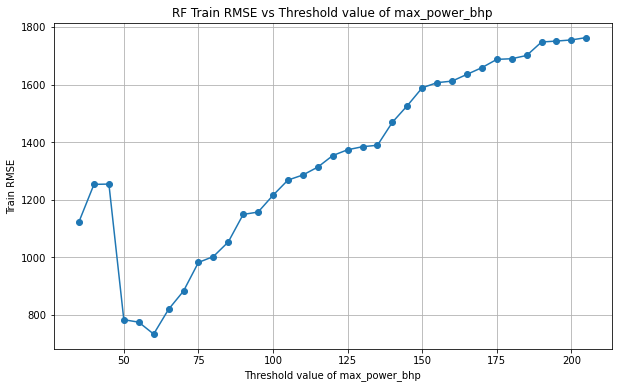

In [756]:
param = {
    'n_estimators': 200,
    'max_depth': 5
}

model = RandomForestRegressor(**param)

model.fit(X_train_2, y_train)

y_pred_train = model.predict(X_train_2)
y_pred_train_df = pd.DataFrame(data=y_pred_train,index=y_train.index)

threshold_values = range(35, 210, 5)
rmse_values = []

for threshold in threshold_values:
    indices_small_max_power_bhp = X_train_2[X_train_2.max_power_bhp > threshold].index
    rmse = sqrt(mean_squared_error(y_train.drop(indices_small_max_power_bhp), y_pred_train_df.drop(indices_small_max_power_bhp)))
    rmse_values.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(threshold_values, rmse_values, marker='o')
plt.xlabel('Threshold value of max_power_bhp')
plt.ylabel('Train RMSE')
plt.title('RF Train RMSE vs Threshold value of max_power_bhp')
plt.grid(True)
plt.show()

We see a similar pattern as before: the training RMSE has some initial fluctuations probably due to the fact that not many data points are taken into account, and it steadily increases for higher values of max_power_bhp. However, one has to remember that random forests are not affected by higher order effects like polynomial models are. Thus, if the RMSE increases for higher values of max_power_bhp, we have to conclude that either the data in this region is much more noisy or that our predictors don't contain some information that becomes very important in this region of the data set. If the issue is just random noise, then collecting more data might help to improve the accuracy of the model. However, given how noisy the data seems to be, this is not guaranteed to help. Alternatively, we might try to consider more variables, hoping that they explain some of the variability that our current variables cannot explain. For example, we might build a model that also takes into account the brand and the model of the cars. Unfortunately, this model would almost certainly contain a lot of hot-encoded variables, and so it might be very complex and difficult to interpret. Alternatively, we could use the name column that we have dropped at the beginning to determine the original price of the car when it was new. While this information is not necessarily strongly correlated with selling_price, it might interact in interesting ways with variables like owner or km_driven. Also, if this were the case we could improve the accuracy of the model without having do add dozens of hot-encoded dummy variables. In addition, not only the model would be simpler, but it would also better generalize to new data points. In fact, if we create dummy variables for either the car brand or the car model, it might happen that a new data point contains information about a car brand of model that has not been observed during training, and so this kind of model would not be able to account for it. On the contrary, we are fairly confident that we could determine the original price for any car model, and so a model that uses this information to make predictions could be used with virtually any new data point. 

In [775]:
print('Train RMSE tuned rf smaller 100: %.2f' % sqrt(mean_squared_error(y_train_smaller_100, rf_tuned.predict(X_train_smaller_100))))
print('Test RMSE tuned rf smaller 100: %.2f' % sqrt(mean_squared_error(y_test_smaller_100, rf_tuned.predict(X_test_smaller_100))))
print('R^2 tuned rf smaller 100: %.3f' % rf_tuned.score(X_train_smaller_100, y_train_smaller_100))

print()

print('Train RMSE tuned rf larger 100: %.2f' % sqrt(mean_squared_error(y_train_larger_100, rf_tuned.predict(X_train_larger_100))))
print('Test RMSE tuned rf larger 100: %.2f' % sqrt(mean_squared_error(y_test_larger_100, rf_tuned.predict(X_test_larger_100))))
print('R^2 tuned rf smaller 100: %.3f' % rf_tuned.score(X_train_larger_100, y_train_larger_100))

Train RMSE tuned rf smaller 100: 331.64
Test RMSE tuned rf smaller 100: 814.63
R^2 tuned rf smaller 100: 0.984

Train RMSE tuned rf larger 100: 859.31
Test RMSE tuned rf larger 100: 2313.17
R^2 tuned rf smaller 100: 0.993


The above results indicate that the test RMSE of the tuned forest is 0.8k dollars for  max_power_bhp < 100, and 2.3k dollars for  max_power_bhp > 100.

Just for fun, let's check what happens if we train two random forests in these separate regions of the data. 

In [ ]:
param_grid = {
    'n_estimators': range(50, 600, 100),
    'max_features':['sqrt', 'log2', None],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10, 20]
}

rf_trial = RandomForestRegressor(n_jobs=-1)

grid_search = GridSearchCV(estimator=rf_trial, param_grid=param_grid,
                           cv=KFold(n_splits=5), n_jobs=-1, scoring=rmse_scorer)

grid_search.fit(X_train_smaller_100, y_train_smaller_100)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 450}


In [772]:
rf_smaller_100_tuned = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=5,n_estimators=450, n_jobs=-1, random_state=0)

rf_smaller_100_tuned.fit(X_train_smaller_100, y_train_smaller_100)

y_pred_test_rf_smaller_100_tuned = rf_smaller_100_tuned.predict(X_test_smaller_100)
y_pred_train_rf_smaller_100_tuned = rf_smaller_100_tuned.predict(X_train_smaller_100)

print('Train RMSE tuned rf smaller 100: %.2f' % sqrt(mean_squared_error(y_train_smaller_100, y_pred_train_rf_smaller_100_tuned)))
print('Test RMSE tuned rf smaller 100: %.2f' % sqrt(mean_squared_error(y_test_smaller_100, y_pred_test_rf_smaller_100_tuned)))
print('R^2 tuned rf smaller 100: %.3f' % rf_smaller_100_tuned.score(X_train_smaller_100, y_train_smaller_100))

Train RMSE tuned rf smaller 100: 479.12
Test RMSE tuned rf smaller 100: 808.94
R^2 tuned rf smaller 100: 0.966


In [760]:
param_grid = {
    'n_estimators': range(50, 600, 100),
    'max_features':['sqrt', 'log2', None],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10, 20]
}

rf_trial = RandomForestRegressor(n_jobs=-1)

grid_search = GridSearchCV(estimator=rf_trial, param_grid=param_grid,
                           cv=KFold(n_splits=5), n_jobs=-1, scoring=rmse_scorer)

grid_search.fit(X_train_larger_100, y_train_larger_100)

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 450}


In [773]:
rf_larger_100_tuned = RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=1, min_samples_split=2,n_estimators=450, n_jobs=-1, random_state=0)

rf_larger_100_tuned.fit(X_train_larger_100, y_train_larger_100)

y_pred_test_rf_larger_100_tuned = rf_larger_100_tuned.predict(X_test_larger_100)
y_pred_train_rf_larger_100_tuned = rf_larger_100_tuned.predict(X_train_larger_100)

print('Train RMSE tuned rf larger 100: %.2f' % sqrt(mean_squared_error(y_train_larger_100, y_pred_train_rf_larger_100_tuned)))
print('Test RMSE tuned rf larger 100: %.2f' % sqrt(mean_squared_error(y_test_larger_100, y_pred_test_rf_larger_100_tuned)))
print('R^2 tuned rf larger 100: %.3f' % rf_larger_100_tuned.score(X_train_larger_100, y_train_larger_100))

Train RMSE tuned rf larger 100: 845.46
Test RMSE tuned rf larger 100: 2268.25
R^2 tuned rf larger 100: 0.993


These results are essentially the same as before. This is not surprising because decision trees make predictions by splitting the data in many regions, and so the trees in the original model probably already split the data at max_power_bhp = 100. Thus, constraining these models to consider these separate regions of the data brings no real advantage.

### Summary

Our goal was to obtain a simple, interpretable model to predict the selling price of used cars. In the process of cleaning the data, we dropped a few columns that we deemed not useful or that might have complicated the model a lot. We also noticed that the data set contained several outliers. To avoid dropping a very large portion of the data, we only dropped the extremely high outliers. Once the cleaning process was complete, our data set had 11 columns (10 variables + 1 target) and 7301 rows.

Throughout the project, we used the RMSE as the metric to evaluate the models performance. We started by constructing a linear model containing all variables. Since some predictors were correlated, this model contained parameters that were not statistically significant. To address this issue, and to simplify the model, we selected a subset of the variables. Both forward and backward selection indicated that the best variables were year, km_driven, max_power_bhp, fuel_diesel, transmission_manual. The linear model trained with these variables gave had a test RMSE of 3.5k dollars and an $R^2$ of 0.7. The test data for selling_price has a mean of 7k dollars and a standard deviation of 6.6k dollars, with 25th and 75th percentiles of 3.4k and 8.3k dollars respectively. This indicates that our predictions are quite inaccurate. 

Next, we added second-order terms. In this case, backward and forward selection indicated different features. After experimenting a bit, we concluded that the 7 beast features were year max_power_bhp, max_power_bhp, max_power_bhp transmission_manual, transmission_manual, year transmission_manual, km_driven, max_power_bhp fuel_diesel. These are just combinations of the features selected by the linear model. The test RMSE of this model was 2.4k dollars, and the $R^2$ was 0.86. While these predictions are not extremely accurate, they are much better than the ones of linear model. This model is reasonably simple, and we have shown how it could be approximated to a linear model in certain regions of the data set. 

Analyzing the residuals of the polynomial model we obtained, we noticed that its accuracy significantly decreased for values of max_power_bhp larger than 100, which is the 75th percentile. Specifically, for max_power_bhp < 100, the test RMSE is 1.4k dollars, while for for max_power_bhp > 100, the test RMSE is 3.9k dollars. Now, for max_power_bhp < 100, the mean is 5k dollars, the standard deviation is 2.6k dollars, the 25th percentile is 3k dollars, and the 75th percentile is 7k dollars. Thus, a test RMSE of 1.4k dollars is fairly good. However, for max_power_bhp > 100, the mean is 13k dollars, the standard deviation is 10k dollars, the 25th percentile is 6.2k dollars, and the 75th percentile is 15.6k dollars. Thus, despite the high fluctuations, at least half of the data is in the range 10K $\pm$ 5k dollars, and so our test RMSE of 3.9k dollars is fairly bad. 

To further explore this, we trained two models in these regions of the data, using the same features we selected before. This time, for max_power_bhp < 100 we obtained a test RMSE of 1.27k dollars and an $R^2$ of 0.765, while for max_power_bhp > 100 we obtained a test RMSE of 3.8k dollars and an $R^2$ of 0.84. These results indicate that training separate models on different parts of the data set is not particularly advantageous. However, we noticed that even a simple linear model with the 5 features we previously selected has a test RMSE of 1.36k dollars and an $R^2$ of 0.73 when trained in the region where max_power_bhp < 100. Thus, if one is interested only in this region of the data, a simple linear model is reasonably accurate. In addition, we observed that the test RMSE significantly improves (3.1k dollars) in the max_power_bhp > 100 region if we consider all possible degree 2 polynomial terms. This suggests that much more flexible models are needed in this region of the data.

Next, we used highly flexible, non-interpretable tree-based models to obtain more accurate predictions. The tuned random forest had a test RMSE of 1.4k dollars and an $R^2$ of 0.993. The tuned XGB regressor performed slightly worse. Like in the previous cases, we noticed that performance decreased for high values of max_power_bhp. Since these models are very flexible, we conclude that the data in this region must be very noisy, or that in this region more predictors are needed to make accurate predictions. For example, considering the brand and model of the cars might help. Alternatively, we might include information that is not present in the original data set, like the original price of the car when it was new.

Finally, we assessed that the random forest trained on the whole data set had test RMSE = 0.8k dollars and $R^2$ = 0.984 for max_power_bhp < 100, and test RMSE = 2.3k dollars and $R^2$ = 0.993 for max_power_bhp > 100. So, the predictions for max_power_bhp < 100 are very good, while the predictions for max_power_bhp > 100 are decent. Training separate models in these regions of the data set lead to essentially identical results. This is expected because decision trees make predictions by splitting the data in several regions, and so it is easy for the model to account for drastically different patterns in the data by making a split at max_power_bhp = 100. 

### Conclusion and Future Work

To conclude, we obtained an interpretable second-order polynomial model with 7 variables. This model makes reasonably good predictions for max_power_bhp < 100 (test RMSE = 1.4k dollars, and test RMSE = 1.27k dollars if we train the model only in this region of the data), and bad predictions for max_power_bhp > 100 (test RMSE = 3.9k dollars). If we are only interested in the region where max_power_bhp < 100, a linear model with 5 features trained in this region makes reasonably good predictions (RMSE = 1.36k dollars). However, first and second-order polynomials are not adequate for describing the region where  max_power_bhp > 100. In addition, we obtained a random forest that has a test RMSE of 1.4k dollars on the whole test data, a test RMSE of 0.8k dollars for max_power_bhp < 100, and a test RMSE of 2.3k dollars for max_power_bhp > 100.

In the future, we should explore why the accuracy of the predictions significantly decreases for max_power_bhp > 100. If collecting more data in this region is not possible, we might want to take into account the brand and model of the cars. Although this will probably make the models significantly more complex (to the point where they will not be easily interpretable), these variables might contain information that is essential to make accurate predictions in this region of the data. However, a potential issue with this kind of model is that it might struggle to make predictions with certain new data points. In fact, if a car brand or model has not been observed during training, the model will not contain dummy variables useful for this new data point, and so the predictions will not take into account the car's brand and model. An alternative approach might be to use the name column that we originally dropped to search for the original price of the car when it was new. While this new variables might not necessarily be strongly correlated with selling_price, it might interact with variables like owner or km_driven. In addition, it is reasonable to believe that we would be able to find this kind of information for essentially any new data point. Finally, we would avoid adding dozens of dummy variables to the model, and so the new model might still be simple enough to be interpretable. 

Data source: https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv

In [798]:
df.to_pickle('df.pkl')
X_train_2.to_pickle('X_train.pkl')
X_test_2.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')
X_train_smaller_100.to_pickle('X_train_smaller_100.pkl')
X_test_smaller_100.to_pickle('X_test_smaller_100.pkl')
y_train_smaller_100.to_pickle('y_train_smaller_100.pkl')
y_test_smaller_100.to_pickle('y_test_smaller_100.pkl')
X_train_larger_100.to_pickle('X_train_larger_100.pkl')
X_test_larger_100.to_pickle('X_test_larger_100.pkl')
y_train_larger_100.to_pickle('y_train_larger_100.pkl')
y_test_larger_100.to_pickle('y_test_larger_100.pkl')